# CLUSTERING PROJECT

The idea of the work is to create a user-friendly app for comparing players having a similar playing style. Thus, the perspective in which we aim is to help scouting. Having defined a starting player, the n players most similar to his playing style will be suggested and compared.

Economic data on the various players, obtained through scraping, are also provided.
Starting from various data sets made available by SICS and Soccerment, we were able to obtain a unique dataset that contains variables considered to be relevant for defining the playing style. We want to try to combine two metrics,similarity between the playing style of two players and the probability of belonging to a certain cluster. Similarity is defined on the basis of cosine similarity, clusters are created on the basis of a Bayesian gaussian mixture model.
The work could undoubtedly be done starting from the entire dataset, but we decided to split the analysis by focusing on role, so that subclasses within those defined by the classical definition of defender, midfielder, and striker are defined.

importing libraries

In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.cm import get_cmap
from matplotlib.ticker import FormatStrFormatter
import pandas as pd
import glob
import os

import seaborn as sns
from scipy import linalg
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import mixture
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import rcParams
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from scipy.spatial import distance
from sklearn.metrics.pairwise import cosine_similarity
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt

# Combining Soccerment, Sics and Skillcorner dataframe

In [2]:
df_socc = pd.read_csv('soccerment_serieA_2021-22_giocatori.csv').set_index('opta_id')


In [3]:
df_sics = pd.read_csv('sics_serieA_2021-22_giocatori.csv')

In [4]:
df_skill = pd.read_csv('skillcorner_serieA_2021-22_giocatori.csv')

To have a mapping between the three datasets one has to create a dictionary made using the names of players and teams

In [5]:
df_dict = pd.read_csv('player_id_serieA_2021-22.csv').set_index('opta_id')

Merge soccerment e sics

In [6]:
df_socc['sics_id'] = df_socc.index.map(df_dict.sics_id)

In [7]:
df_m = df_socc.merge(df_sics, left_on = 'sics_id', right_on = 'id', how = 'inner')

Merge all with skillcorner

In [8]:
df_m.set_index('sics_id',inplace=True)

In [9]:
df_dict.set_index('sics_id',inplace=True)

In [10]:
df_m['skill_id'] = df_m.index.map(df_dict.sc_id)

In [11]:
df = df_m.merge(df_skill, left_on = 'skill_id', right_on = 'Player ID', how = 'inner')

This the resulting dataset

In [12]:
df

full_name  birth_date          country soccRole       team  \
0      Zlatan Ibrahimovic  1981-10-03           Sweden       FW      Milan   
1      Fabio Quagliarella  1983-01-31            Italy       FW  Sampdoria   
2    Francesco Magnanelli  1984-11-12            Italy       CM   Sassuolo   
3       Cristiano Ronaldo  1985-02-05         Portugal       FW   Juventus   
4            Goran Pandev  1983-07-27  North Macedonia       FW      Genoa   
..                    ...         ...              ...      ...        ...   
551        Riccardo Pinzi  2003-08-17            Italy       FW    Udinese   
552  Dimitrios Keramitsis  2004-07-01           Greece       FB       Roma   
553       Moustapha Cissé  2003-09-14           Guinea       FW   Atalanta   
554        Simone Pafundi  2006-03-14            Italy       FW    Udinese   
555   Patrick Thomas Leal  2003-02-21         Portugal       FW    Venezia   

                cluster  games  mins_played  touches        xG  ...  \
0    All-round finisher     23         1008    564.0  6.252449  ...   
1       Mobile finisher     33         1658    724.0  4.259178  ...   
2                   NaN     12          265    282.0  0.040473  ...   
3    All-round finisher      1           31     17.0  0.236411  ...   
4        Chance creator     20          835    381.0  0.464921  ...   
..                  ...    ...          ...      ...       ...  ...   
551                 NaN      1            1      1.0  0.000000  ...   
552                 NaN      1            1      0.0  0.000000  ...   
553                 NaN      3           35     23.0  0.570036  ...   
554                 NaN      1           22     13.0  0.071036  ...   
555                 NaN      1            1      1.0  0.000000  ...   

     Count HSR OTIP  Count Sprint OTIP  Count HI OTIP  \
0             158.0               32.0          190.0   
1             353.0               36.0          389.0   
2              90.0                8.0           98.0   
3               5.0                1.0            6.0   
4             192.0               14.0          206.0   
..              ...                ...            ...   
551             0.0                1.0            1.0   
552             0.0                0.0            0.0   
553            21.0                5.0           26.0   
554            10.0                1.0           11.0   
555             4.0                3.0            7.0   

     Count Medium Acceleration OTIP  Count High Acceleration OTIP  \
0                             227.0                          21.0   
1                             492.0                          21.0   
2                             108.0                           4.0   
3                               6.0                           0.0   
4                             345.0                           9.0   
..                              ...                           ...   
551                             5.0                           0.0   
552                             0.0                           0.0   
553                            23.0                           3.0   
554                            10.0                           1.0   
555                             6.0                           1.0   

     Count Medium Deceleration OTIP  Count High Deceleration OTIP       M/min  \
0                             213.0                          54.0   93.079111   
1                             410.0                          78.0  107.624720   
2                              75.0                          17.0  126.826205   
3                               6.0                           0.0  101.878424   
4                             269.0                          36.0  117.509657   
..                              ...                           ...         ...   
551                             4.0                           0.0  140.000000   
552                             0.0                           0.

## Filter on mins_played

Only players who have played at least 900 minutes (10 games) in the entire league are to be considered

In [13]:
df = df[df.mins_played >= 900.]

### Excluding GK

In [14]:
df = df[df.soccRole != 'GK']

In [15]:
df.shape

(311, 205)

# Selecting variables

I chose not include outcome statistics such as goals, xG and similar, to ensure that the analysis would assess a players’ style.

In [16]:
vars_90 = ['Count High Acceleration OTIP','Count High Acceleration TIP','Count High Deceleration OTIP','Count High Deceleration TIP','Count HSR OTIP','Count HSR TIP','Count Medium Acceleration OTIP','Count Medium Acceleration TIP','Count Medium Deceleration OTIP','Count Medium Deceleration TIP','Count Sprint OTIP','Count Sprint TIP','Distance OTIP','Distance TIP','HI Distance OTIP','HI Distance TIP','HSR Distance OTIP','HSR Distance TIP','Ammonizioni','Assist','Cross','Cut Back','Dribbling','Espulsioni','Falli subiti','In Fuorigioco','Third pass','Tiri','Tiri da area','Tiri di testa','Tiri fuori area','Traversoni','Triangolazioni', 'Palle Laterali', 'Passaggi Chiave','Passaggi Chiave ricevuti']

In [17]:
vars_100 = ['Duelli aerei','Duelli di gioco','Duelli tackle','Falli fatti','Recupera palla','Duelli nella metà campo offensiva']

## Standardizzazione delle variabili

Defensive statistics were possession adjusted, and all statistics were adjusted per 90 minutes.

In [18]:
for i in vars_90:
    df[f'{i}_p90'] = df[i]/(df.mins_played/90.)


In [19]:
for i in vars_100:
    df[f'{i}_p100'] = df[i]/(df.touches/100.)

In [20]:
vars = [s + '_p90' for s in vars_90]+[s + '_p100' for s in vars_100 ]

# Analysis by role

The idea is to estimate through a Bayesian Gaussian mixture model the probability of belonging to a certain cluster. This will identify the various subclusters within the classical roles Defender(D), Midfielders(C) and Strikers(A).

In [21]:
df.Ruolo.unique()

array(['A', 'D', 'C'], dtype=object)

## Defenders Cluster

In [22]:
df_dif = df[df.Ruolo == 'D'][vars]

## Scale

Data are standardized

In [23]:
scaler = MinMaxScaler()

In [24]:
df_dif[vars] = scaler.fit_transform(df_dif.values)


In [25]:
df_dif.describe()

Count High Acceleration OTIP_p90  Count High Acceleration TIP_p90  \
count                        137.000000                       137.000000   
mean                           0.373127                         0.333921   
std                            0.204086                         0.244718   
min                            0.000000                         0.000000   
25%                            0.233148                         0.138794   
50%                            0.335426                         0.223798   
75%                            0.502464                         0.540861   
max                            1.000000                         1.000000   

       Count High Deceleration OTIP_p90  Count High Deceleration TIP_p90  \
count                        137.000000                       137.000000   
mean                           0.329114                         0.360395   
std                            0.209772                         0.233346   
min                            0.000000                         0.000000   
25%                            0.163305                         0.166719   
50%                            0.275768                         0.260522   
75%                            0.463081                         0.572226   
max                            1.000000                         1.000000   

       Count HSR OTIP_p90  Count HSR TIP_p90  \
count          137.000000         137.000000   
mean             0.482060           0.337831   
std              0.196387           0.256223   
min              0.000000           0.000000   
25%              0.327646           0.120825   
50%              0.481185           0.226789   
75%              0.622410           0.559214   
max              1.000000           1.000000   

       Count Medium Acceleration OTIP_p90  Count Medium Acceleration TIP_p90  \
count                          137.000000                         137.000000   
mean                             0.486414                           0.434365   
std                              0.233846                           0.187813   
min                              0.000000                           0.000000   
25%                              0.292129                           0.302118   
50%                              0.495866                           0.405873   
75%                              0.653516                           0.554608   
max                              1.000000                           1.000000   

       Count Medium Deceleration OTIP_p90  Count Medium Deceleration TIP_p90  \
count                          137.000000                         137.000000   
mean                             0.444788                           0.430183   
std                              0.211656                           0.191267   
min                              0.000000                           0.000000   
25%                              0.289639                           0.295149   
50%                              0.433365                           0.419946   
75%                              0.574298                           0.544837   
max                              1.000000                           1.000000   

       ...  Triangolazioni_p90  Palle Laterali_p90  Passaggi Chiave_p90  \
count  ...          137.000000          137.000000           137.000000   
mean   ...            0.249880            0.298056             0.308906   
std    ...            0.219925            0.295701             0.197911   
min    ...            0.000000            0.000000             0.000000   
25%    ...            0.067772            0.034848             0.161875   
50%    ...            0.193026            0.159695             0.253121   
75%    ...            0.373452            0.550854             0.413854   
max    ...            1.000000            1.000000             1.000000   

       Passaggi Chiave ricevuti_p90  Duelli aerei_p100  Duelli di gioco_p100  \
count 

## Explore Data

In [26]:
len(df_dif.columns.values)

42

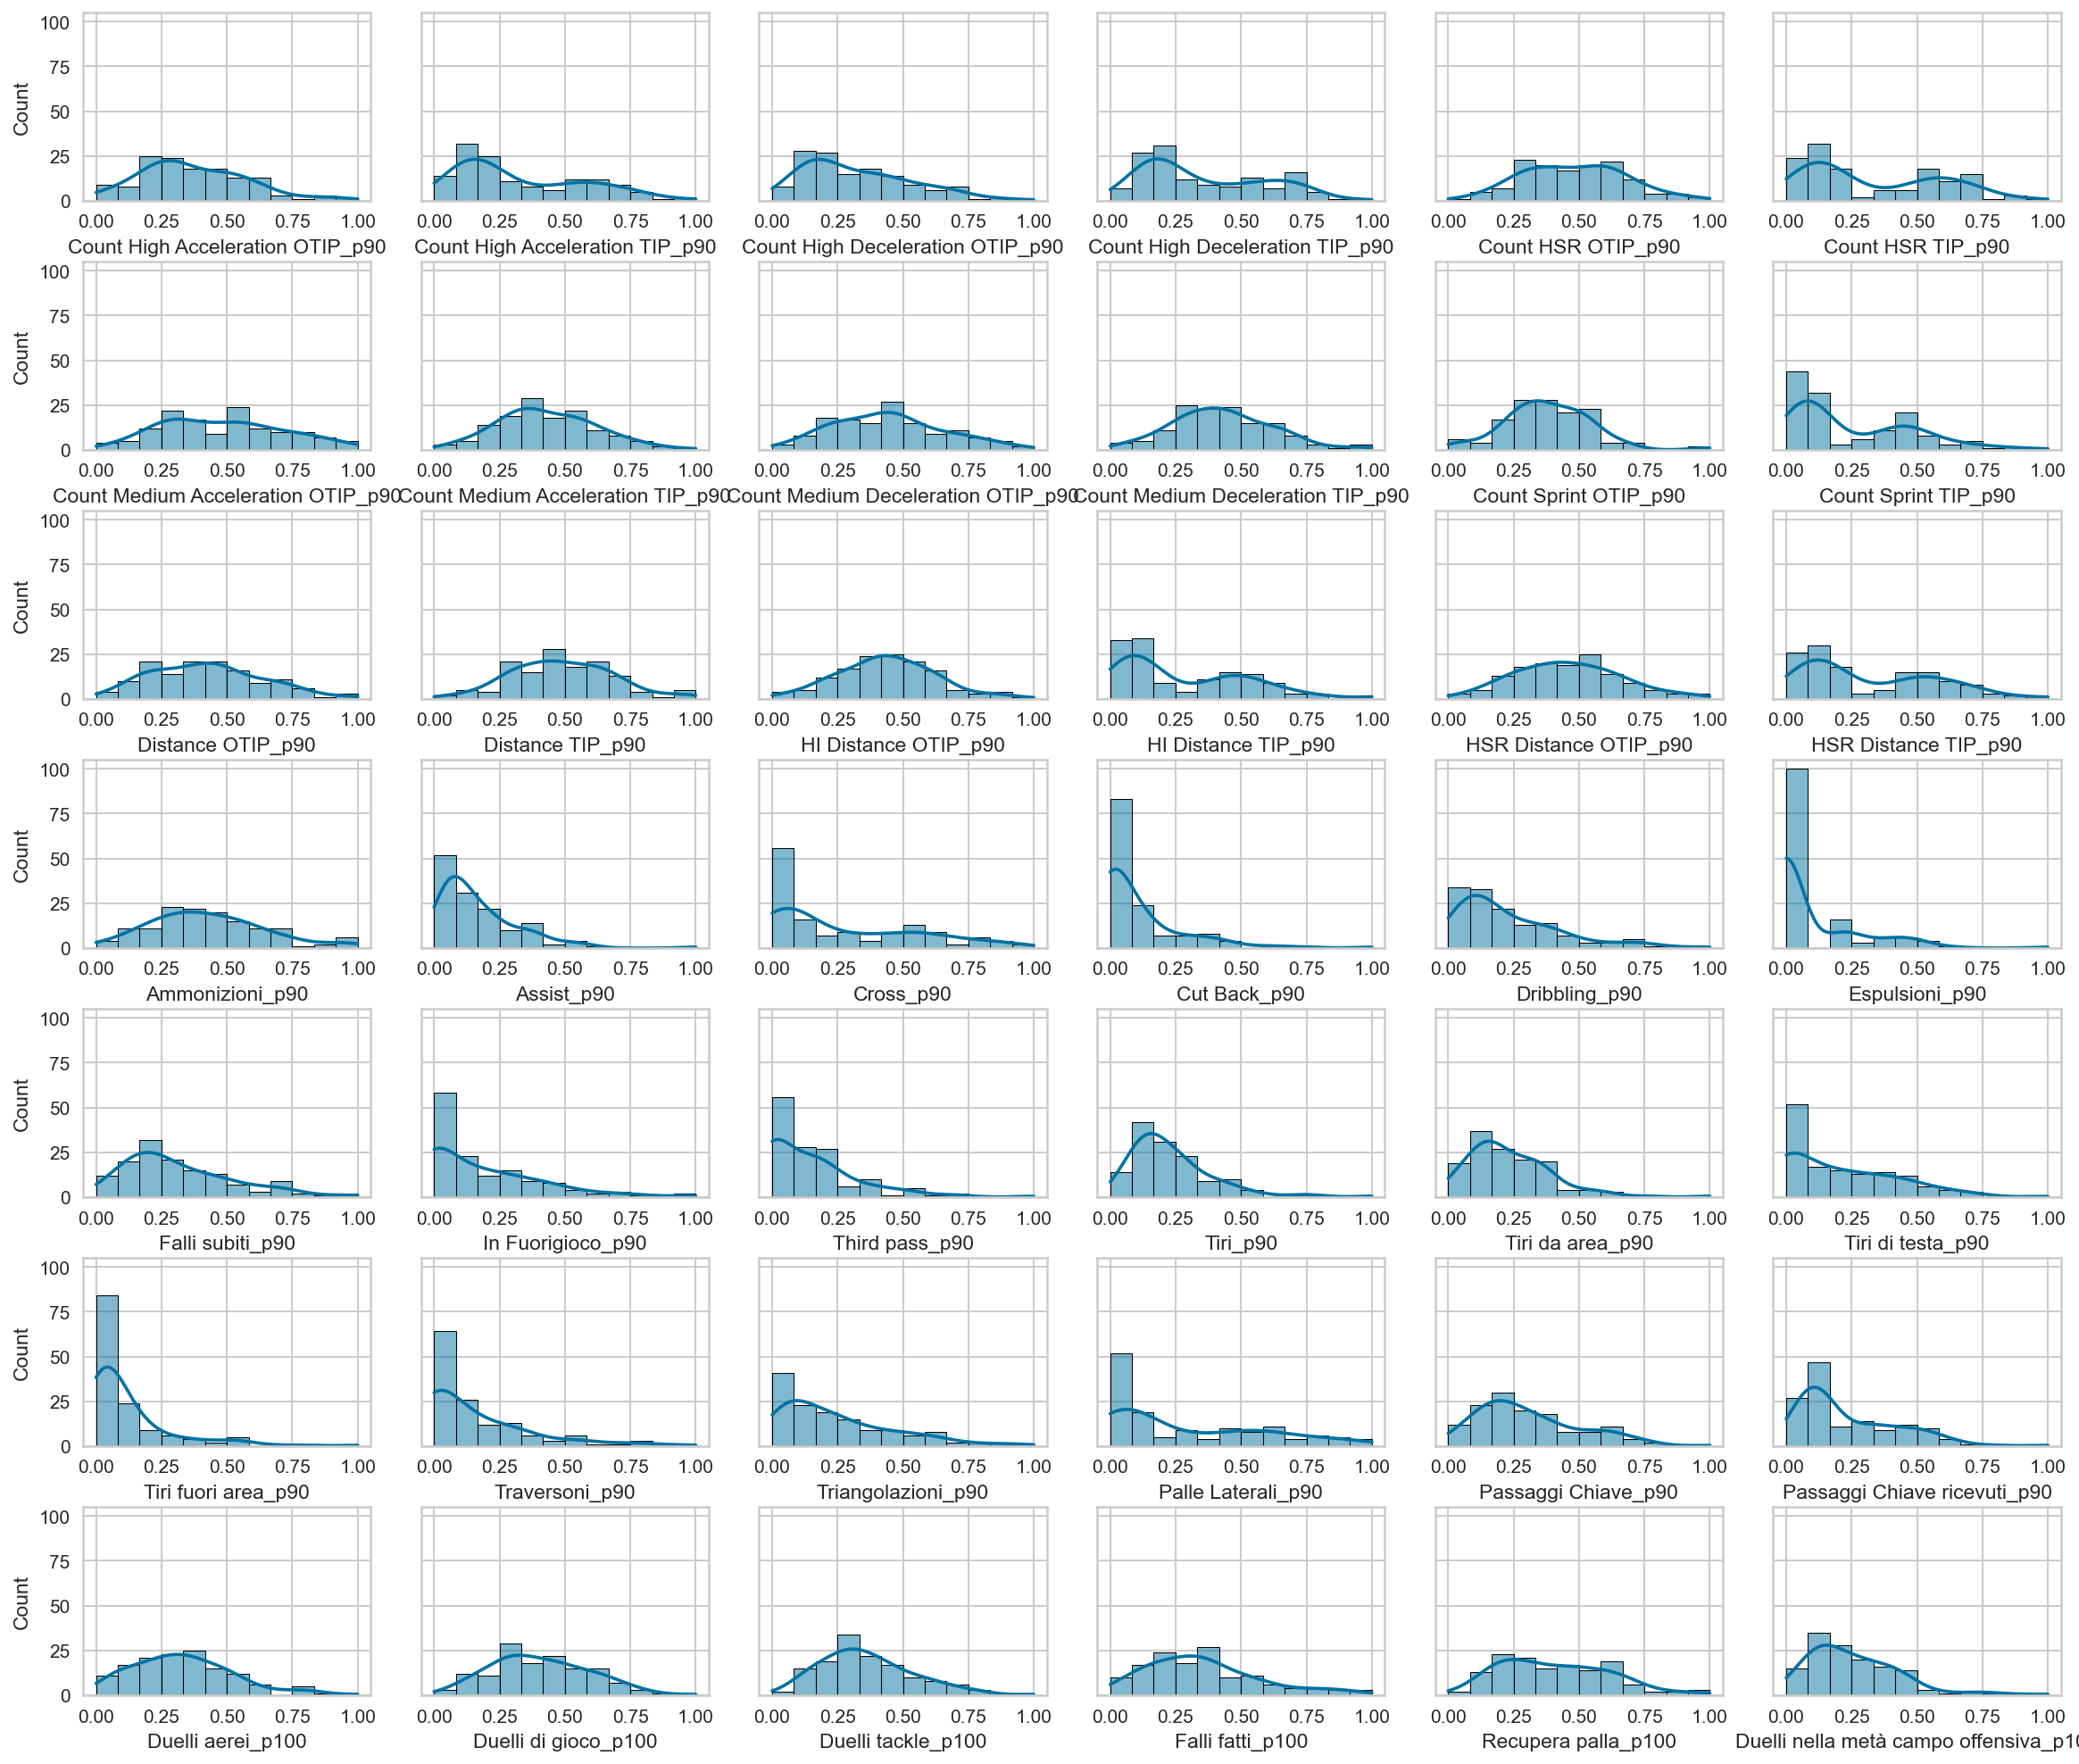

In [27]:
fig, axes = plt.subplots(nrows=7, ncols=6, sharex=False, sharey=True, figsize=(12,12), dpi=150)
fig.tight_layout(rect=[0, 0.4, 1.3, 1.5])

for i in np.arange(0, len(df_dif.columns)):
    axis = fig.get_axes()[i]
    sns.histplot(data=df_dif, x=df_dif.iloc[:,i], bins=12, kde=True, linewidth=0.5, ax=axis)

## Reducing component

Through the method of principal components, the number of columns is reduced

### Principal Component Analysis

[Text(0, 0, ''),
 Text(1, 0, '2'),
 Text(2, 0, ''),
 Text(3, 0, '4'),
 Text(4, 0, ''),
 Text(5, 0, '6'),
 Text(6, 0, ''),
 Text(7, 0, '8'),
 Text(8, 0, ''),
 Text(9, 0, '10'),
 Text(10, 0, ''),
 Text(11, 0, '12'),
 Text(12, 0, ''),
 Text(13, 0, '14'),
 Text(14, 0, ''),
 Text(15, 0, '16'),
 Text(16, 0, ''),
 Text(17, 0, '18'),
 Text(18, 0, ''),
 Text(19, 0, '20'),
 Text(20, 0, ''),
 Text(21, 0, '22'),
 Text(22, 0, ''),
 Text(23, 0, '24'),
 Text(24, 0, ''),
 Text(25, 0, '26'),
 Text(26, 0, ''),
 Text(27, 0, '28'),
 Text(28, 0, ''),
 Text(29, 0, '30'),
 Text(30, 0, ''),
 Text(31, 0, '32'),
 Text(32, 0, ''),
 Text(33, 0, '34'),
 Text(34, 0, ''),
 Text(35, 0, '36'),
 Text(36, 0, ''),
 Text(37, 0, '38'),
 Text(38, 0, ''),
 Text(39, 0, '40'),
 Text(40, 0, ''),
 Text(41, 0, '42')]

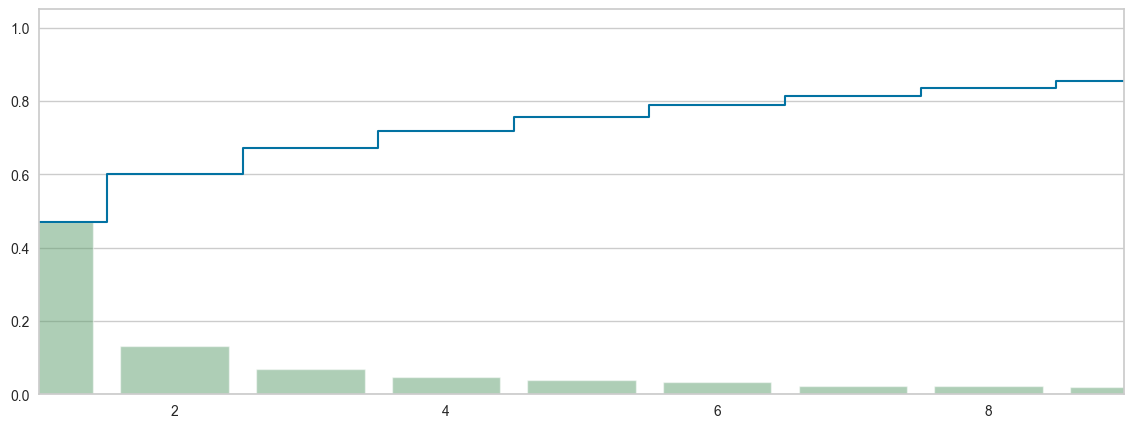

In [28]:
pca = PCA(random_state=0)
pca.fit(df_dif)
pca_samples = pca.transform(df_dif)

fig, ax = plt.subplots(figsize=(14,5))
sns.set(font_scale=1)
plt.step(range(df_dif.shape[1]),pca.explained_variance_ratio_.cumsum(),where='mid',label='cumulative explained variance')
sns.barplot(x = np.arange(1,df_dif.shape[1]+1),y = pca.explained_variance_ratio_,alpha=0.5,color = 'g', label = 'individual explained variance')
plt.xlim(0,8)
ax.set_xticklabels([s if int(s.get_text())%2 ==0 else '' for s in ax.get_xticklabels()])

In order to stay within a perceptible space, the first six components were chosen, and together they absorb nearly 80% of the information. 

In [29]:
n_components = 6
PCA_components = pd.DataFrame(pca_samples[:,:n_components])
PCA_components.index = df_dif.index

In [30]:
PCA_components

0         1         2         3         4         5
6   -0.788621  0.491093 -0.246228 -0.246298 -0.121754 -0.069693
9   -0.086911  0.134454 -0.194265 -0.640981 -0.225814 -0.015547
12   0.633328  0.013311  0.277632 -0.077892  0.101316 -0.064582
15  -1.082288  0.965434 -0.243401 -0.608668  0.329895 -0.145479
25   0.026898  0.793467  0.238451  0.454475  0.391402 -0.081776
..        ...       ...       ...       ...       ...       ...
512 -0.431892 -0.819628  0.018093  0.286107 -0.052605 -0.262942
517 -0.756593 -0.142188 -0.053252  0.174109 -0.134282 -0.085408
520 -0.432152 -0.379635 -0.294233  0.048931  0.097868 -0.047785
527  1.307240 -0.519787 -0.138944 -0.259697  0.233035  0.127379
528  1.208424 -0.157295  0.132076 -0.330611 -0.199230  0.241753

[137 rows x 6 columns]

Through the use of a dendrogram we can get an idea of the number of clusters using the method complete and as a distance the cosine distance

names are saved in a variable for future use

In [31]:
names = df[df.Ruolo=='D'].full_name.to_list()

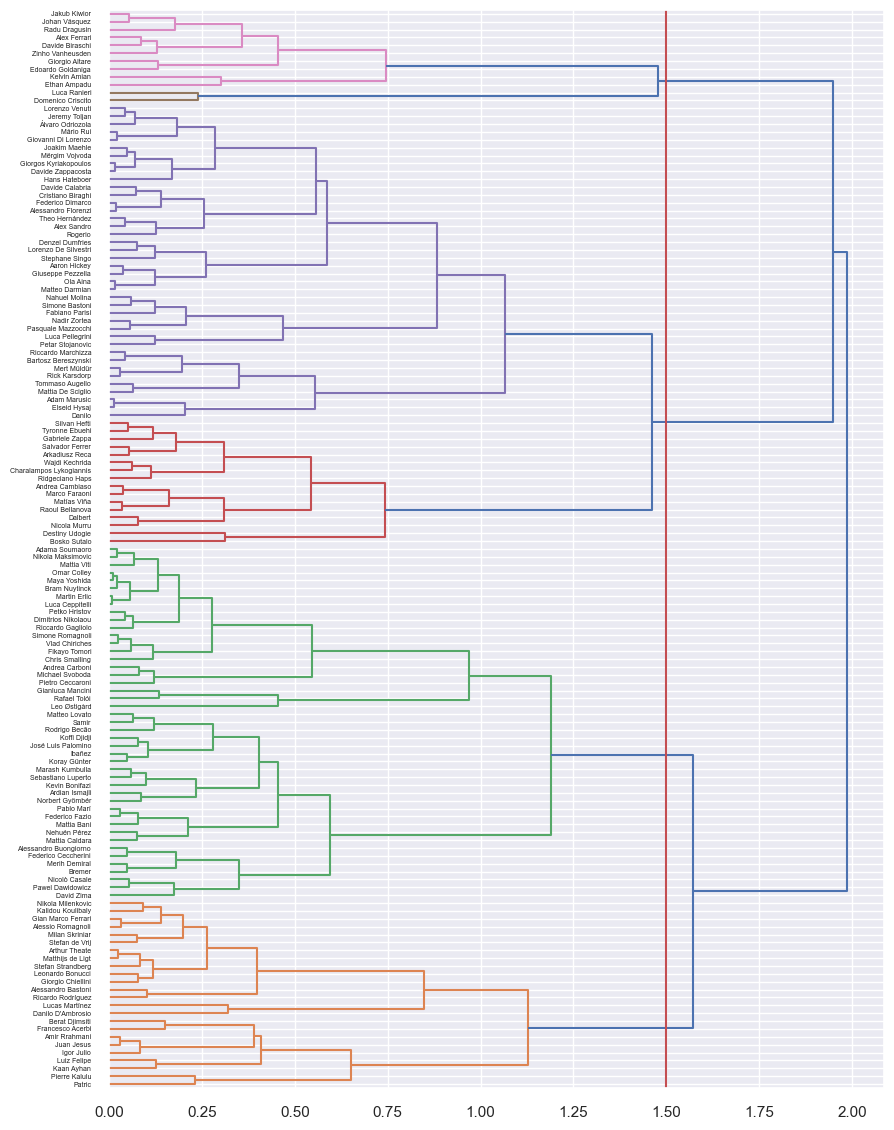

In [32]:
plt.figure(figsize=(10,14))
dendogram = shc.dendrogram(shc.linkage(PCA_components,method='complete',metric= 'cosine'),labels=names, orientation='right')
plt.axvline(x=1.5, color='r', linestyle = '-')

Based on these results we decide to run a Bayesian Gaussian mixture model with 4 clusters. The algorithm will eliminate any unnecessary clusters automatically giving them weights equal (or close) to zero.

# BAYESIAN GAUSSIAN MIXTURE

In [33]:
bay_gmm = BayesianGaussianMixture(n_components= 4, random_state= 0)

In [34]:
bay_gmm.fit(PCA_components)

BayesianGaussianMixture(n_components=4, random_state=0)

In [35]:
bay_gmm_weights = bay_gmm.weights_
np.round(bay_gmm_weights, 2)

array([0.4 , 0.19, 0.24, 0.17])

In [36]:
n_clusters_ = (np.round(bay_gmm_weights, 2) > 0).sum()
print('Estimated number of clusters: ' + str(n_clusters_))

Estimated number of clusters: 4


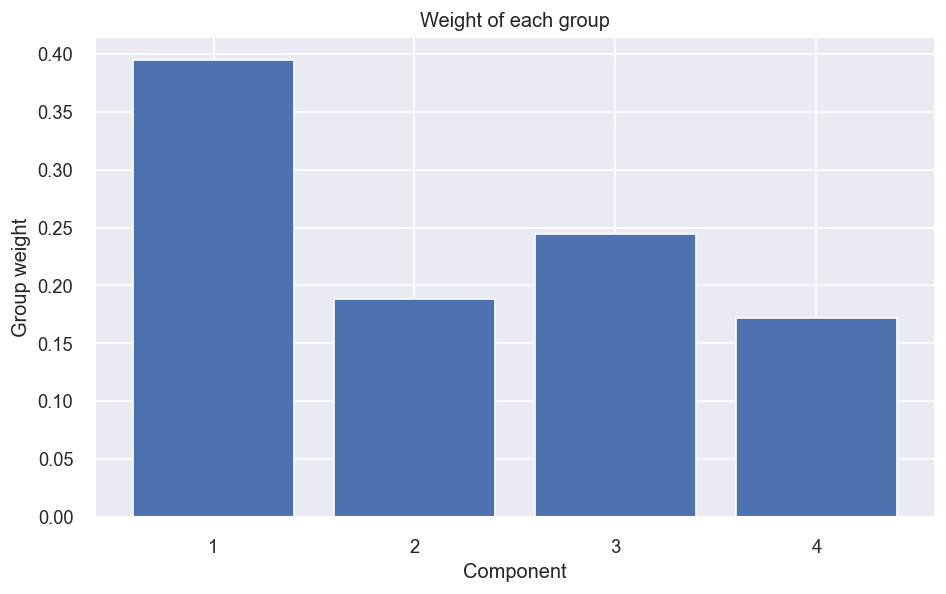

In [37]:
fig = plt.figure(figsize=(7,4), dpi=120)
axes = fig.add_axes([0,0,1,1])
groups = np.arange(len(bay_gmm_weights))
axes.bar(groups, bay_gmm_weights, align='center', alpha=1.0)
plt.xticks(groups, groups + 1)
plt.ylabel('Group weight')
plt.xlabel('Component')
plt.title('Weight of each group')
plt.show()

In [38]:
y_pred  = bay_gmm.predict(PCA_components)

In [39]:
df_dif['cluster_bay'] = y_pred

In [40]:
df_dif['gm_cluster_prob0'] = bay_gmm.predict_proba(PCA_components)[:,0]
df_dif['gm_cluster_prob1'] = bay_gmm.predict_proba(PCA_components)[:,1]
df_dif['gm_cluster_prob2'] = bay_gmm.predict_proba(PCA_components)[:,2]
df_dif['gm_cluster_prob3'] = bay_gmm.predict_proba(PCA_components)[:,3]

In [41]:
df_dif['name']=df[df.Ruolo=='D'].full_name

In [42]:
palette = {
    0: 'blue',
    1: 'green',
    2: 'orange',
    3: 'red'
}

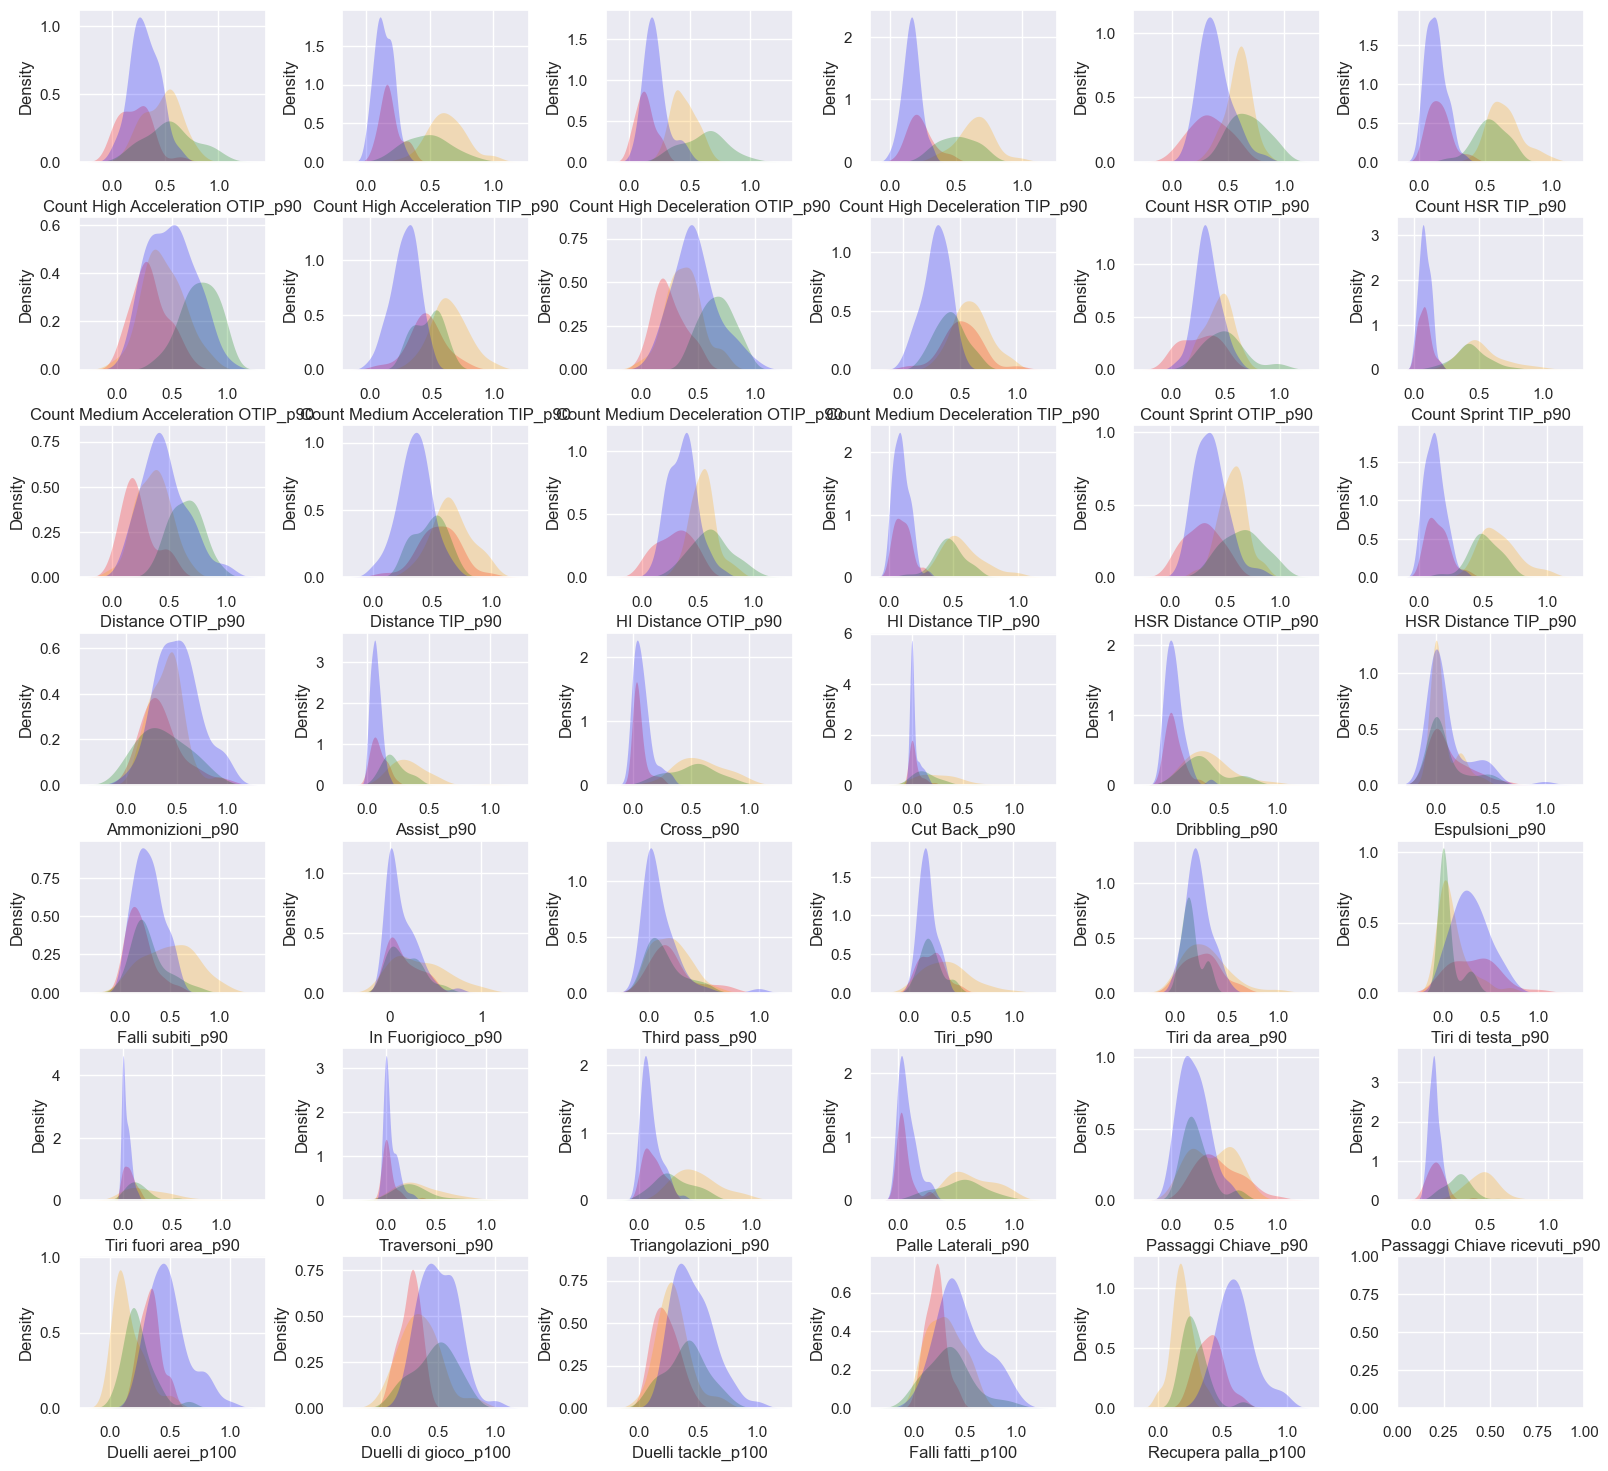

In [43]:
fig, axes = plt.subplots(nrows=7, ncols=6, figsize=(16,16))
#fig.suptitle(f"Feature distributions - by label", fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

for i in np.arange(0, len(df_dif[vars].columns)-1):
    axis = fig.get_axes()[i]
    sns.kdeplot(data=df_dif, x=df_dif.iloc[:,i], hue="cluster_bay", palette= palette, fill=True, linewidth=0, ax=axis,legend = False)
    #plt.legend(loc='upper center')

In [44]:
dfsg_b= df_dif.groupby('cluster_bay')[vars].mean()
dfsg_b

Count High Acceleration OTIP_p90  \
cluster_bay                                     
0                                    0.305435   
1                                    0.549902   
2                                    0.467838   
3                                    0.211056   

             Count High Acceleration TIP_p90  \
cluster_bay                                    
0                                   0.137945   
1                                   0.484438   
2                                   0.636084   
3                                   0.187933   

             Count High Deceleration OTIP_p90  \
cluster_bay                                     
0                                    0.211011   
1                                    0.614357   
2                                    0.449365   
3                                    0.130708   

             Count High Deceleration TIP_p90  Count HSR OTIP_p90  \
cluster_bay                                                        
0                                   0.163496            0.385029   
1                                   0.512857            0.682965   
2                                   0.648744            0.596069   
3                                   0.233203            0.331810   

             Count HSR TIP_p90  Count Medium Acceleration OTIP_p90  \
cluster_bay                                                          
0                     0.126538                            0.491666   
1                     0.539853                            0.752759   
2                     0.652544                            0.420986   
3                     0.155741                            0.297917   

             Count Medium Acceleration TIP_p90  \
cluster_bay                                      
0                                     0.281284   
1                                     0.464324   
2                                     0.638694   
3                                     0.451053   

             Count Medium Deceleration OTIP_p90  \
cluster_bay                                       
0                                      0.475687   
1                                      0.667234   
2                                      0.377180   
3                                      0.248783   

             Count Medium Deceleration TIP_p90  ...  Triangolazioni_p90  \
cluster_bay                                     ...                       
0                                     0.286851  ...            0.104485   
1                                     0.412910  ...            0.316379   
2                                     0.603027  ...            0.516672   
3                                     0.516252  ...            0.128781   

             Palle Laterali_p90  Passaggi Chiave_p90  \
cluster_bay                                            
0                      0.082350             0.214848   
1                      0.533421             0.247594   
2                      0.634727             0.391814   
3                      0.062113             0.456867   

             Passaggi Chiave ricevuti_p90  Duelli aerei_p100  \
cluster_bay                                                    
0                                0.099272           0.489846   
1                                0.295070           0.240439   
2                                0.493139           0.156338   
3                                0.121608           0.337159   

             Duelli di gioco_p100  Duelli tackle_p100  Falli fatti_p100  \
cluster_bay                                                               
0                        0.500453            0.457102          0.462422   
1                        0.462034            0.398703          0.344854   
2                        0.341138            0.290345          0.303689   
3                        0.247715            0.223788          0.206543   

             Recupera palla_p100  Duelli nella metà campo offensiva_p100

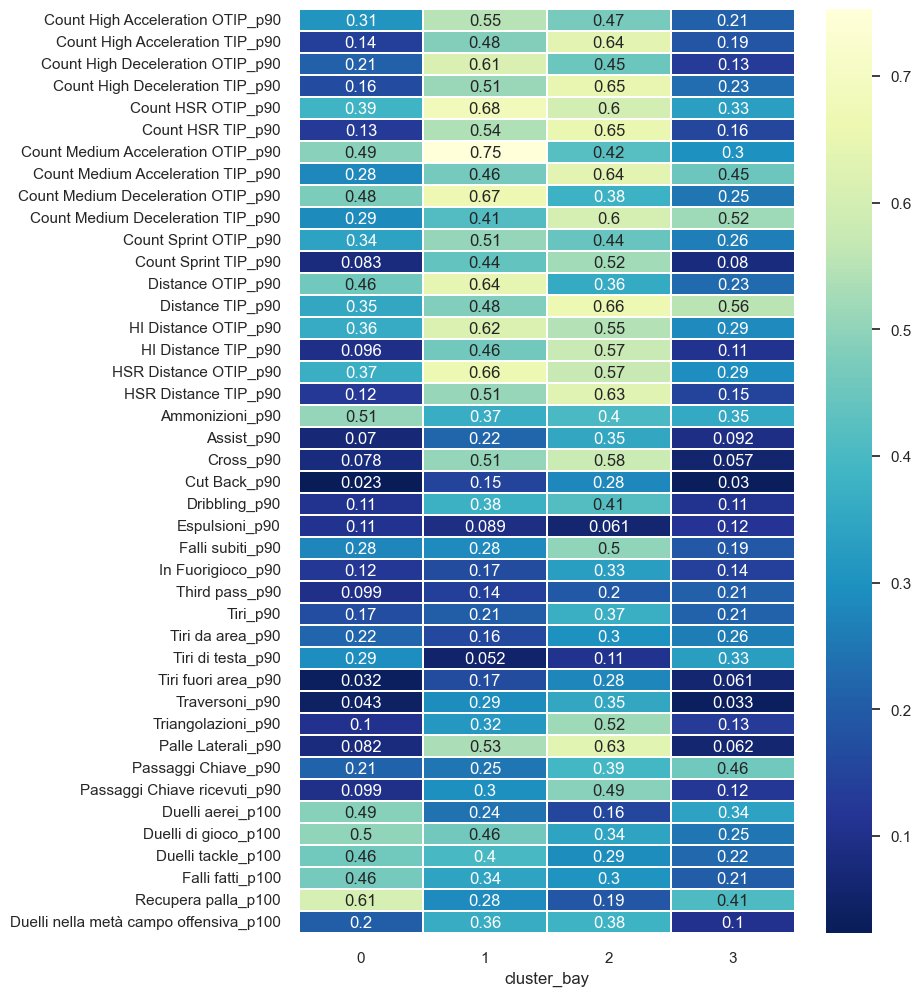

In [45]:
plt.figure(figsize = (8,12))
sns.heatmap(dfsg_b.T, cmap = 'YlGnBu_r',linewidths = 0.30, annot = True)
plt.show()

1. In the first cluster we find defenders with a high number of duels, related to a high value of cautions. One can clearly see how offensive type statistics have particularly low values for these players. It is therefore expected that they are the players destined to stop the action. Indeed, in this cluster we find players such as Bremer, Chris Smalling, and Nikola Maksimovic.

2. In the second cluster we can see values similar to the third cluster with higher values, however, regarding duels of play and lower dribbling. Good values regarding physical metrics. These are players who play a role on the wing but with less offensive characteristics than in the third cluster. We find in this cluster players such as Marusic, De Sciglio and Elseid Hysaj. 

3. To the third cluster belong players who present important values for Lateral_P90 balls, statistics related to running and distance and we find interesting values for crosses. Thus, defenders who play on the wing who make a good number of dribbles and crosses will belong to this cluster. Defenders such as for example Federico Dimarco, Álvaro Odriozola, Alex Sandro, Cristiano Biraghi and Theo Hernández are found in this cluster.

4. Players with fairly high values on Distance_TIP_90 and key passes belong to the fourth cluster. We can see that compared to the other clusters they present a lower number of duels and fouls made. The numbers on aerial duels and recovered balls are slightly higher than the other defenders. This is interesting, as they have good numbers on recovered balls but relatively few duels made. One might infer that these are players who therefore present good field placement. This suggests to us that in this cluster we go to find players who usually play the classic role of central defender. Indeed, we find among these players such as Bonucci, Skriniar, Milenkovic, and De Vrij

By using the Bayesian Gaussian model we can have the probability for each player to belong to a certain cluster, and we see that there are, for example, some hybrid players:

In [46]:
df_dif['hybrid'] = df_dif[['gm_cluster_prob0', 'gm_cluster_prob1','gm_cluster_prob2','gm_cluster_prob3']].max(axis = 1) < 2./3

In [47]:
df_dif[df_dif.hybrid][['name', 'cluster_bay', 'gm_cluster_prob0', 'gm_cluster_prob1','gm_cluster_prob2','gm_cluster_prob3']]

name  cluster_bay  gm_cluster_prob0  gm_cluster_prob1  \
374  Mert Müldür            2      1.099613e-09          0.355667   

     gm_cluster_prob2  gm_cluster_prob3  
374          0.644303           0.00003

## Midfielders Cluster 

We are going to perform the same steps for Midfielders Cluster

In [48]:
df_cen = df[df.Ruolo == 'C'][vars]

In [49]:
scaler = MinMaxScaler()
df_cen[vars]= scaler.fit_transform(df_cen.values)
df_cen.describe()

Count High Acceleration OTIP_p90  Count High Acceleration TIP_p90  \
count                        111.000000                       111.000000   
mean                           0.393357                         0.370111   
std                            0.190735                         0.179294   
min                            0.000000                         0.000000   
25%                            0.270848                         0.251693   
50%                            0.372172                         0.345093   
75%                            0.509902                         0.438357   
max                            1.000000                         1.000000   

       Count High Deceleration OTIP_p90  Count High Deceleration TIP_p90  \
count                        111.000000                       111.000000   
mean                           0.365332                         0.376458   
std                            0.170391                         0.200638   
min                            0.000000                         0.000000   
25%                            0.241625                         0.227617   
50%                            0.326033                         0.339889   
75%                            0.493698                         0.489912   
max                            1.000000                         1.000000   

       Count HSR OTIP_p90  Count HSR TIP_p90  \
count          111.000000         111.000000   
mean             0.396332           0.522646   
std              0.186986           0.225465   
min              0.000000           0.000000   
25%              0.262333           0.376219   
50%              0.394160           0.509432   
75%              0.509640           0.681431   
max              1.000000           1.000000   

       Count Medium Acceleration OTIP_p90  Count Medium Acceleration TIP_p90  \
count                          111.000000                         111.000000   
mean                             0.473426                           0.481926   
std                              0.187950                           0.193798   
min                              0.000000                           0.000000   
25%                              0.371019                           0.339789   
50%                              0.464867                           0.468033   
75%                              0.587448                           0.612902   
max                              1.000000                           1.000000   

       Count Medium Deceleration OTIP_p90  Count Medium Deceleration TIP_p90  \
count                          111.000000                         111.000000   
mean                             0.431703                           0.439042   
std                              0.207138                           0.210081   
min                              0.000000                           0.000000   
25%                              0.274552                           0.274986   
50%                              0.425658                           0.451694   
75%                              0.569479                           0.561631   
max                              1.000000                           1.000000   

       ...  Triangolazioni_p90  Palle Laterali_p90  Passaggi Chiave_p90  \
count  ...          111.000000          111.000000           111.000000   
mean   ...            0.334826            0.206154             0.372661   
std    ...            0.184209            0.177673             0.214553   
min    ...            0.000000            0.000000             0.000000   
25%    ...            0.200443            0.077858             0.222384   
50%    ...            0.309650            0.161212             0.336506   
75%    ...            0.432669            0.269497             0.486973   
max    ...            1.000000            1.000000             1.000000   

       Passaggi Chiave ricevuti_p90  Duelli aerei_p100  Duelli di gioco_p100  \
count 

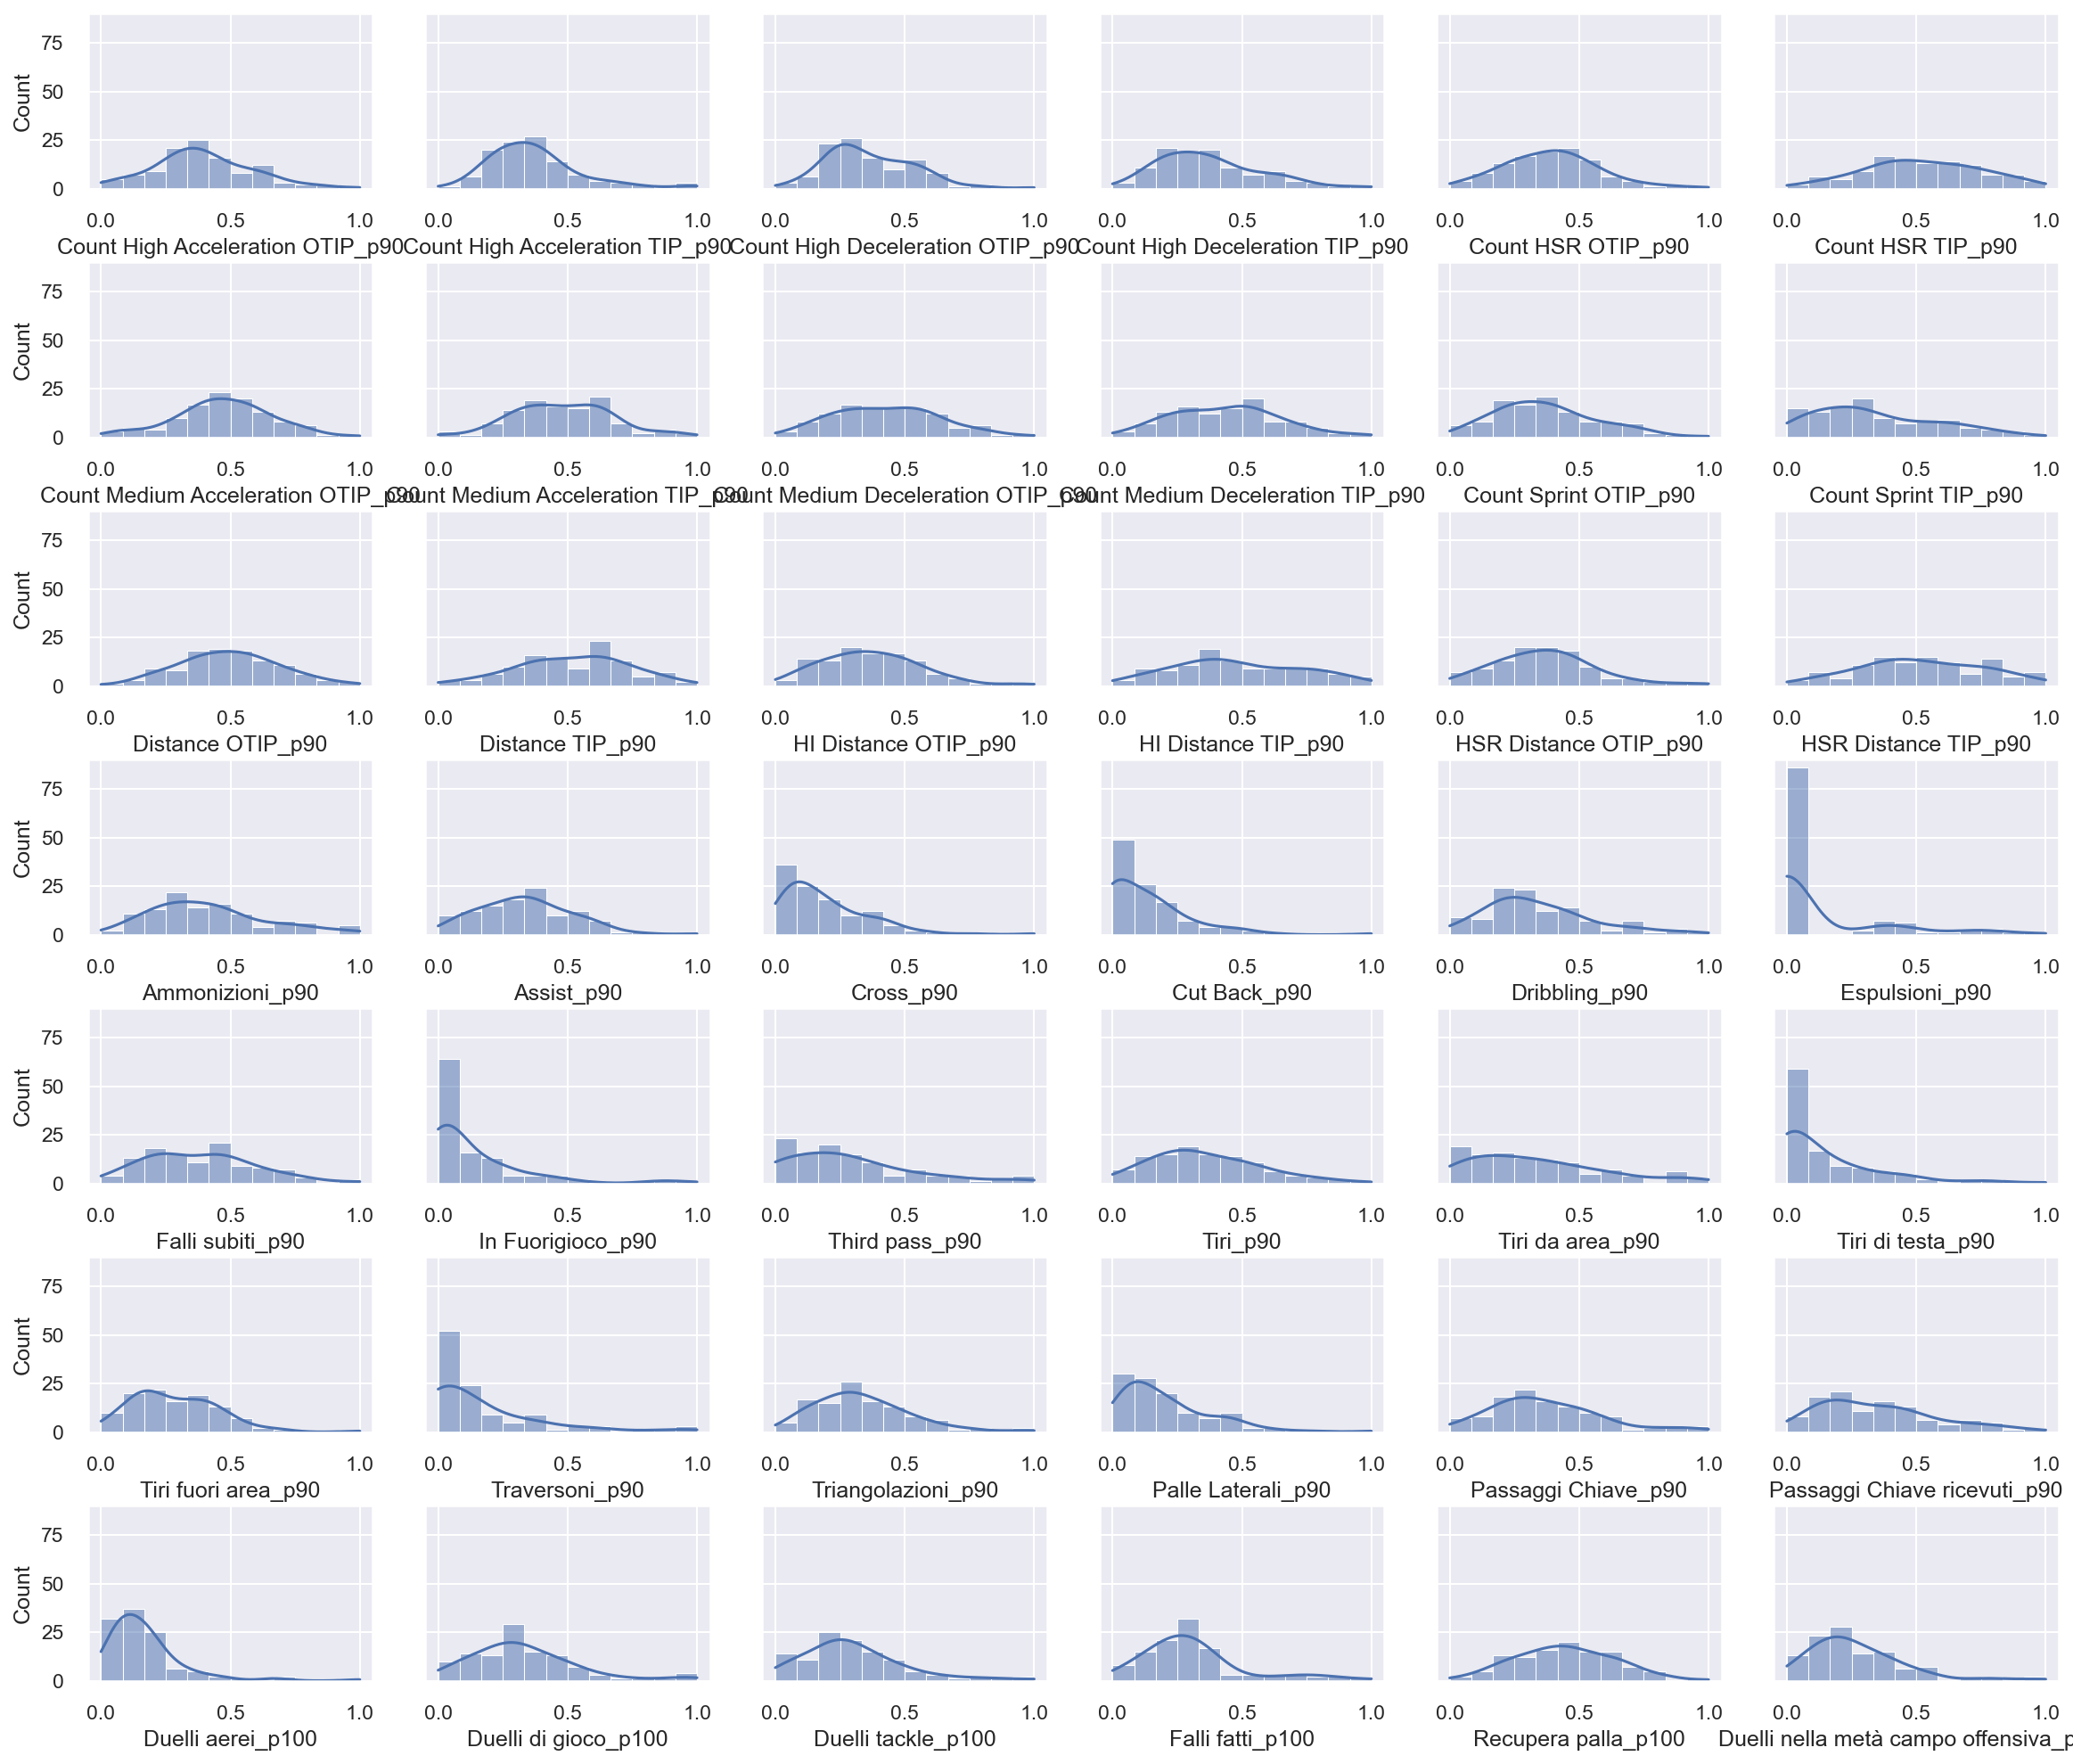

In [50]:
fig, axes = plt.subplots(nrows=7, ncols=6, sharex=False, sharey=True, figsize=(12,12), dpi=150)
fig.tight_layout(rect=[0, 0.4, 1.3, 1.5])

for i in np.arange(0, len(df_cen.columns)):
    axis = fig.get_axes()[i]
    sns.histplot(data=df_cen, x=df_cen.iloc[:,i], bins=12, kde=True, linewidth=0.5, ax=axis)

## Reducing components

[Text(0, 0, ''),
 Text(1, 0, '2'),
 Text(2, 0, ''),
 Text(3, 0, '4'),
 Text(4, 0, ''),
 Text(5, 0, '6'),
 Text(6, 0, ''),
 Text(7, 0, '8'),
 Text(8, 0, ''),
 Text(9, 0, '10'),
 Text(10, 0, ''),
 Text(11, 0, '12'),
 Text(12, 0, ''),
 Text(13, 0, '14'),
 Text(14, 0, ''),
 Text(15, 0, '16'),
 Text(16, 0, ''),
 Text(17, 0, '18'),
 Text(18, 0, ''),
 Text(19, 0, '20'),
 Text(20, 0, ''),
 Text(21, 0, '22'),
 Text(22, 0, ''),
 Text(23, 0, '24'),
 Text(24, 0, ''),
 Text(25, 0, '26'),
 Text(26, 0, ''),
 Text(27, 0, '28'),
 Text(28, 0, ''),
 Text(29, 0, '30'),
 Text(30, 0, ''),
 Text(31, 0, '32'),
 Text(32, 0, ''),
 Text(33, 0, '34'),
 Text(34, 0, ''),
 Text(35, 0, '36'),
 Text(36, 0, ''),
 Text(37, 0, '38'),
 Text(38, 0, ''),
 Text(39, 0, '40'),
 Text(40, 0, ''),
 Text(41, 0, '42')]

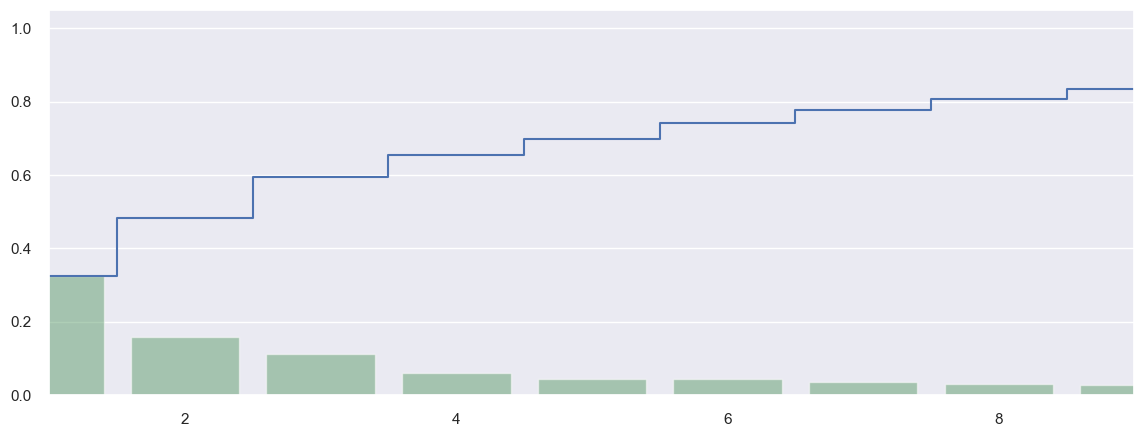

In [54]:
pca = PCA(random_state=0)
pca.fit(df_cen)
pca_samples = pca.transform(df_cen)

fig, ax = plt.subplots(figsize=(14,5))
sns.set(font_scale=1)
plt.step(range(df_cen.shape[1]),pca.explained_variance_ratio_.cumsum(),where='mid',label='cumulative explained variance')
sns.barplot(x = np.arange(1,df_cen.shape[1]+1),y = pca.explained_variance_ratio_,alpha=0.5,color = 'g', label = 'individual explained variance')
plt.xlim(0,8)
ax.set_xticklabels([s if int(s.get_text())%2 ==0 else '' for s in ax.get_xticklabels()])


In [55]:
n_components = 7
PCA_components = pd.DataFrame(pca_samples[:,:n_components])
PCA_components.index = df_cen.index

PCA_components

0         1         2         3         4         5         6
8   -0.910672 -0.130591  0.110879  0.448429  0.324390  0.186674  0.518338
29  -1.315751 -0.250721  0.840103  0.484779 -0.362289 -0.297911  0.434817
38  -1.126857 -0.020997 -0.395424 -0.503452 -0.123379  0.156385  0.157741
41   1.206690 -0.116574 -0.580656  0.759861 -0.499988  0.016356  0.467927
42   1.304893 -0.194790 -0.909550  1.098180  0.292576 -0.034506  0.311609
..        ...       ...       ...       ...       ...       ...       ...
463 -0.811076 -0.187205 -0.088545 -0.107148 -0.116315  0.201617 -0.067713
464 -0.544000 -0.092355 -0.014435  0.232934  0.106275 -0.001829  0.014393
472  0.211363 -0.008071  0.242142 -0.543900 -0.033912  0.101822  0.389117
476  0.233059  0.923168  0.078151 -0.258769  0.196115  0.228549 -0.042542
531 -0.904796 -0.083379 -0.023016  0.239343 -0.097263 -0.268215 -0.174921

[111 rows x 7 columns]

In [56]:
names = df[df.Ruolo=='C'].full_name.to_list()


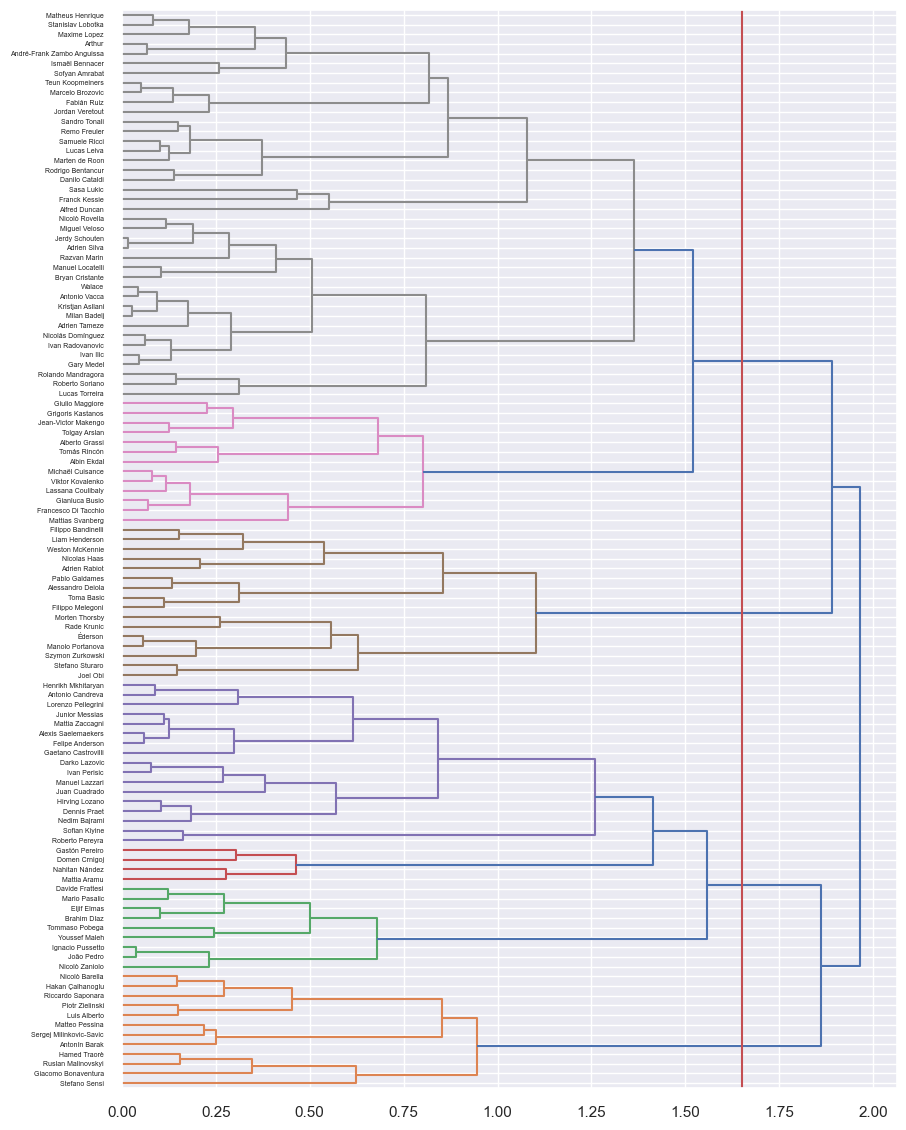

In [57]:
plt.figure(figsize=(10,14))
dendogram = shc.dendrogram(shc.linkage(PCA_components,method='complete',metric= 'cosine'),labels=names, orientation='right')
plt.axvline(x=1.65, color='r', linestyle = '-')

We decide to set 4 cluster:

In [58]:
bay_gmm = BayesianGaussianMixture(n_components=4, random_state= 0)

In [59]:
bay_gmm.fit(PCA_components)

BayesianGaussianMixture(n_components=4, random_state=0)

In [60]:
bay_gmm_weights = bay_gmm.weights_
np.round(bay_gmm_weights, 2)

array([0.12, 0.38, 0.42, 0.08])

In [61]:
n_clusters_ = (np.round(bay_gmm_weights, 2) > 0).sum()
print('Estimated number of clusters: ' + str(n_clusters_))

Estimated number of clusters: 4


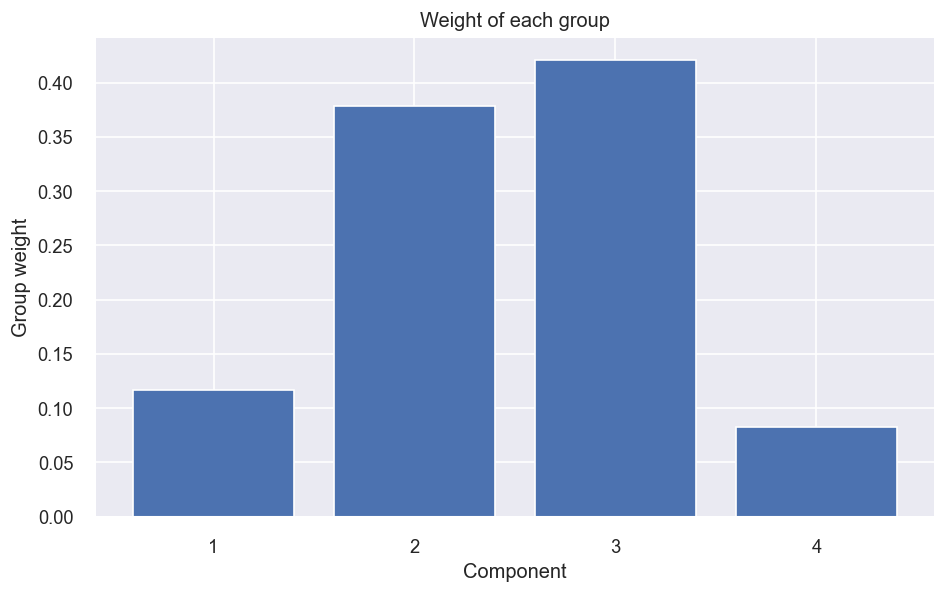

In [62]:
fig = plt.figure(figsize=(7,4), dpi=120)
axes = fig.add_axes([0,0,1,1])
groups = np.arange(len(bay_gmm_weights))
axes.bar(groups, bay_gmm_weights, align='center', alpha=1.0)
plt.xticks(groups, groups + 1)
plt.ylabel('Group weight')
plt.xlabel('Component')
plt.title('Weight of each group')
plt.show()


In [63]:
y_pred  = bay_gmm.predict(PCA_components)

In [64]:
df_cen['cluster_bay'] = y_pred

In [65]:
df_cen['gm_cluster_prob0'] = bay_gmm.predict_proba(PCA_components)[:,0]
df_cen['gm_cluster_prob1'] = bay_gmm.predict_proba(PCA_components)[:,1]
df_cen['gm_cluster_prob2'] = bay_gmm.predict_proba(PCA_components)[:,2]
df_cen['gm_cluster_prob3'] = bay_gmm.predict_proba(PCA_components)[:,3]


In [66]:
df_cen['name']=df[df.Ruolo=='C'].full_name

In [67]:
palette = {
    0: 'blue',
    1: 'green',
    2: 'orange',
    3: 'red'
}

C:\Users\giova\AppData\Local\Temp\ipykernel_6876\1891234656.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df_cen, x=df_cen.iloc[:,i], hue="cluster_bay", palette= palette, fill=True, linewidth=0, ax=axis,legend = False)


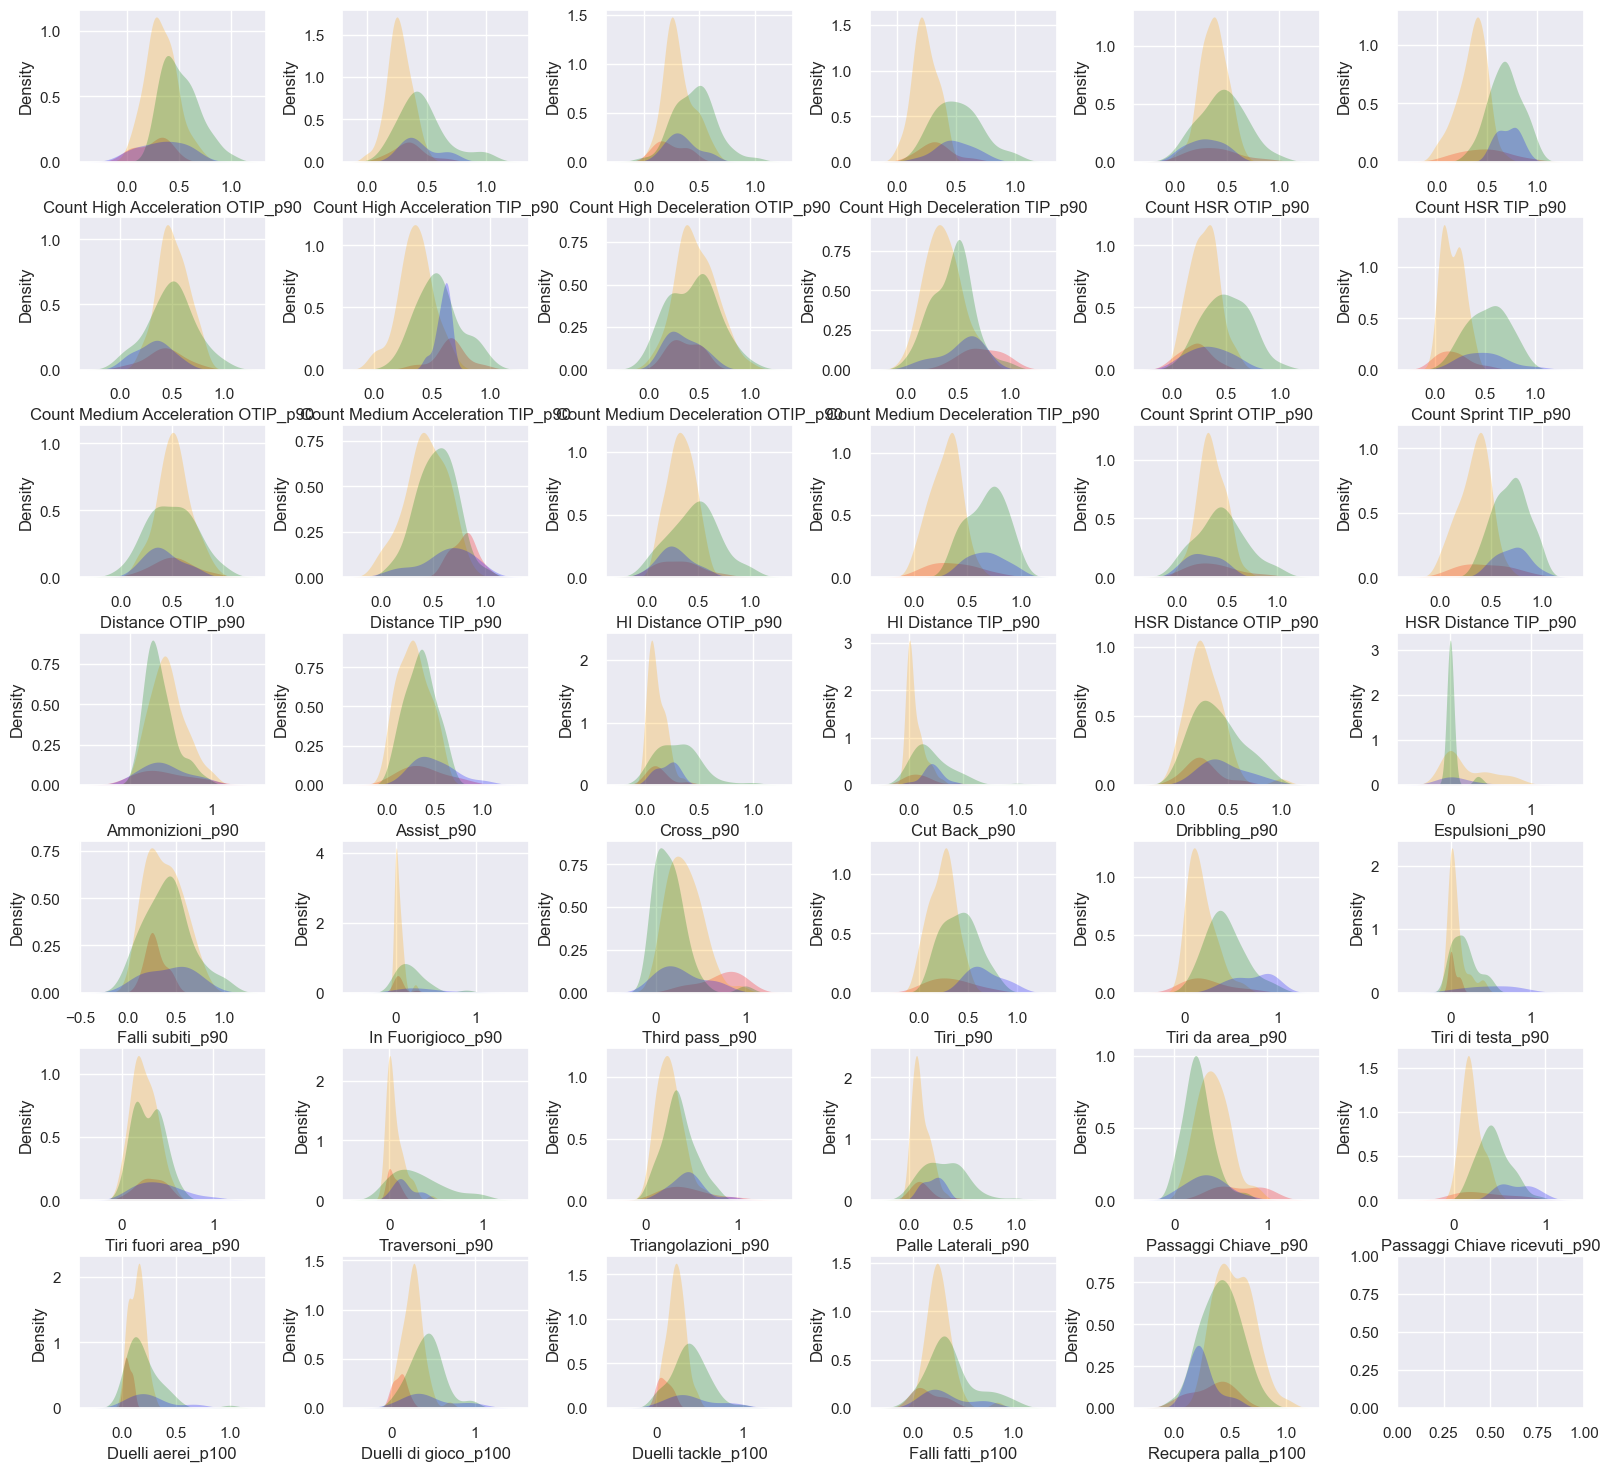

In [68]:
fig, axes = plt.subplots(nrows=7, ncols=6, figsize=(16,16))
#fig.suptitle(f"Feature distributions - by label", fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

for i in np.arange(0, len(df_cen[vars].columns)-1):
    axis = fig.get_axes()[i]
    sns.kdeplot(data=df_cen, x=df_cen.iloc[:,i], hue="cluster_bay", palette= palette, fill=True, linewidth=0, ax=axis,legend = False)
    #plt.legend(loc='upper center')

In [69]:
dfsg_b= df_cen.groupby('cluster_bay')[vars].mean()
dfsg_b

Count High Acceleration OTIP_p90  \
cluster_bay                                     
0                                    0.340496   
1                                    0.513187   
2                                    0.329358   
3                                    0.245966   

             Count High Acceleration TIP_p90  \
cluster_bay                                    
0                                   0.447560   
1                                   0.467946   
2                                   0.268411   
3                                   0.352677   

             Count High Deceleration OTIP_p90  \
cluster_bay                                     
0                                    0.345293   
1                                    0.459146   
2                                    0.311853   
3                                    0.239475   

             Count High Deceleration TIP_p90  Count HSR OTIP_p90  \
cluster_bay                                                        
0                                   0.491333            0.292263   
1                                   0.513475            0.458775   
2                                   0.236182            0.369147   
3                                   0.332020            0.388683   

             Count HSR TIP_p90  Count Medium Acceleration OTIP_p90  \
cluster_bay                                                          
0                     0.710480                            0.324081   
1                     0.679893                            0.486907   
2                     0.347688                            0.507968   
3                     0.471494                            0.425425   

             Count Medium Acceleration TIP_p90  \
cluster_bay                                      
0                                     0.597392   
1                                     0.555170   
2                                     0.355998   
3                                     0.657782   

             Count Medium Deceleration OTIP_p90  \
cluster_bay                                       
0                                      0.340185   
1                                      0.435656   
2                                      0.465234   
3                                      0.356450   

             Count Medium Deceleration TIP_p90  ...  Triangolazioni_p90  \
cluster_bay                                     ...                       
0                                     0.527217  ...            0.457247   
1                                     0.445512  ...            0.362082   
2                                     0.357456  ...            0.257774   
3                                     0.726411  ...            0.455343   

             Palle Laterali_p90  Passaggi Chiave_p90  \
cluster_bay                                            
0                      0.220450             0.352447   
1                      0.330748             0.256143   
2                      0.107111             0.419133   
3                      0.133889             0.695516   

             Passaggi Chiave ricevuti_p90  Duelli aerei_p100  \
cluster_bay                                                    
0                                0.688144           0.271202   
1                                0.436921           0.203520   
2                                0.195070           0.133618   
3                                0.339231           0.054228   

             Duelli di gioco_p100  Duelli tackle_p100  Falli fatti_p100  \
cluster_bay                                                               
0                        0.464430            0.430987          0.345926   
1                        0.427083            0.389180          0.386093   
2                        0.258211            0.232020          0.264861   
3                        0.100223            0.095941          0.149271   

             Recupera palla_p100  Duelli nella metà campo offensiva_p100

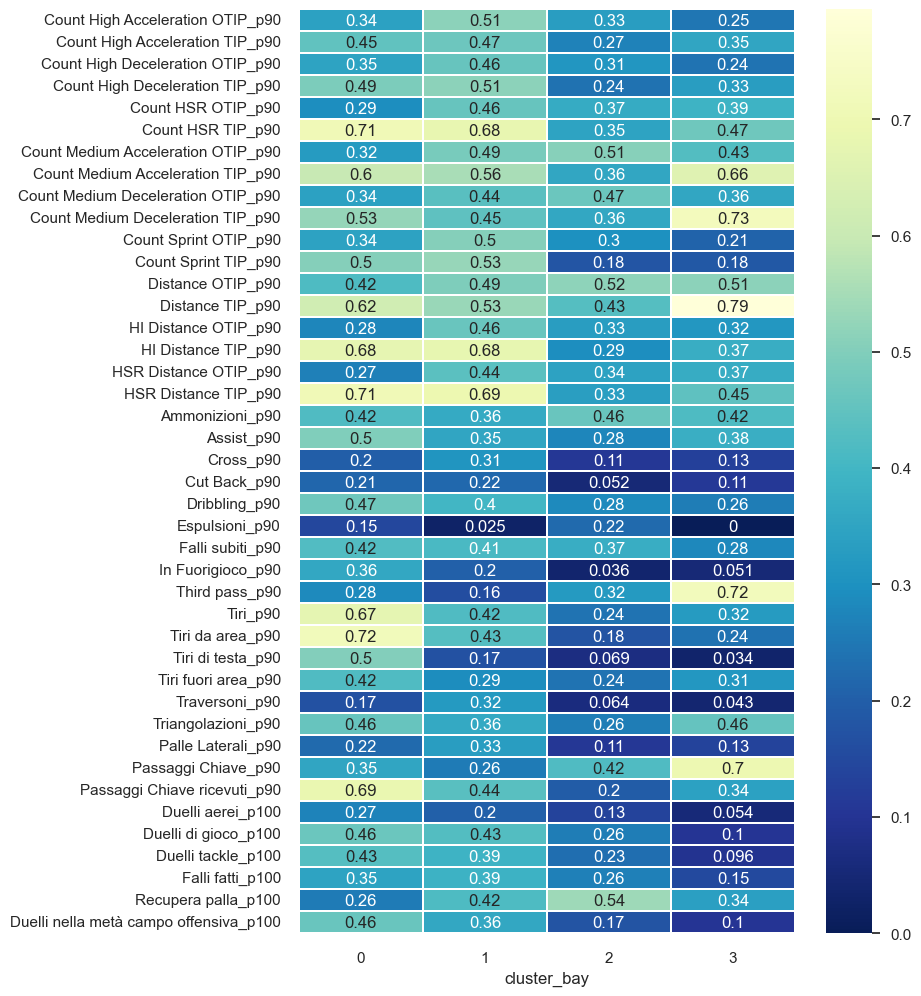

In [70]:
plt.figure(figsize = (8,12))
sns.heatmap(dfsg_b.T, cmap = 'YlGnBu_r',linewidths = 0.30, annot = True)
plt.show()

1. In the first cluster we find midfielders with important levels regarding typically offensive metrics and with high numbers of key passes received. They therefore provide more contribution in the finalization phase. Among them we find players such as Milinkovic-Savic, Zaniolo, Pasalic, and McKennie.

2. In the second cluster we can see similar values to the first cluster. Thus, we have quite high values regarding offensive metrics but compared to the first cluster we have more balls recovered and higher values regarding defensive physical metrics (OTIP). Duels are mostly carried out in the offensive half of the field . In addition we have higher values regarding crosses. Among the clusters the players in this one have the highest number of cut backs. Players such as Gaetano Castrovilli, Henrikh Mkhitaryan, Brahim Díaz, Ivan Perisic are found in this cluster. 

3. To the third cluster belong players with the highest value of stolen balls compared to all. There are lower average values of duels than in the first two clusters but these are mostly done in the defensive half of the field. There is also an important difference between the physical metrics in offense and defense. Thus we have in this cluster more defensive midfielders. One finds for example Lucas Torreira, Gary Medel, Milan Badelj.

4. Belonging to the fourth cluster are players who make many key passes, many third passes (the pass before the assist) and triangulations. The game duels are mainly developed in the defensive half of the field, where they manage to recover a good number of balls. They then distribute the ball within the team. Within this cluster are players such as Sofyan Amrabat, Marcelo Brozovic, Fabián Ruiz and Manuel Locatelli

In [70]:
df_cen['hybrid'] = df_cen[['gm_cluster_prob0', 'gm_cluster_prob1','gm_cluster_prob2','gm_cluster_prob3']].max(axis = 1) < 2./3

In [71]:
df_cen[df_cen.hybrid][['name', 'cluster_bay', 'gm_cluster_prob0', 'gm_cluster_prob1','gm_cluster_prob2','gm_cluster_prob3']]

name  cluster_bay  gm_cluster_prob0  gm_cluster_prob1  \
309  Teun Koopmeiners            2          0.043097          0.009535   
324        Sasa Lukic            1          0.000007          0.555411   

     gm_cluster_prob2  gm_cluster_prob3  
309          0.626012          0.321355  
324          0.444029          0.000553

## Cluster attacanti 

In [72]:
df_att = df[df.Ruolo == 'A'][vars]

In [73]:
scaler = MinMaxScaler()
df_att[vars]= scaler.fit_transform(df_att.values)
df_att.describe()

Count High Acceleration OTIP_p90  Count High Acceleration TIP_p90  \
count                         63.000000                        63.000000   
mean                           0.369311                         0.454351   
std                            0.235901                         0.206540   
min                            0.000000                         0.000000   
25%                            0.206717                         0.298934   
50%                            0.330614                         0.441728   
75%                            0.484149                         0.569501   
max                            1.000000                         1.000000   

       Count High Deceleration OTIP_p90  Count High Deceleration TIP_p90  \
count                         63.000000                        63.000000   
mean                           0.528685                         0.438210   
std                            0.216388                         0.183478   
min                            0.000000                         0.000000   
25%                            0.377324                         0.314961   
50%                            0.499402                         0.462083   
75%                            0.659561                         0.555254   
max                            1.000000                         1.000000   

       Count HSR OTIP_p90  Count HSR TIP_p90  \
count           63.000000          63.000000   
mean             0.430685           0.429632   
std              0.252341           0.201751   
min              0.000000           0.000000   
25%              0.227325           0.286945   
50%              0.378595           0.445700   
75%              0.604007           0.555043   
max              1.000000           1.000000   

       Count Medium Acceleration OTIP_p90  Count Medium Acceleration TIP_p90  \
count                           63.000000                          63.000000   
mean                             0.424256                           0.494078   
std                              0.238535                           0.243665   
min                              0.000000                           0.000000   
25%                              0.248437                           0.327550   
50%                              0.439503                           0.503302   
75%                              0.593566                           0.658243   
max                              1.000000                           1.000000   

       Count Medium Deceleration OTIP_p90  Count Medium Deceleration TIP_p90  \
count                           63.000000                          63.000000   
mean                             0.384645                           0.419576   
std                              0.208371                           0.248386   
min                              0.000000                           0.000000   
25%                              0.241319                           0.210325   
50%                              0.361632                           0.405320   
75%                              0.517562                           0.599338   
max                              1.000000                           1.000000   

       ...  Triangolazioni_p90  Palle Laterali_p90  Passaggi Chiave_p90  \
count  ...           63.000000           63.000000            63.000000   
mean   ...            0.386131            0.347257             0.320360   
std    ...            0.258150            0.264487             0.248393   
min    ...            0.000000            0.000000             0.000000   
25%    ...            0.201281            0.138324             0.112509   
50%    ...            0.318599            0.298201             0.311123   
75%    ...            0.594667            0.547430             0.514106   
max    ...            1.000000            1.000000             1.000000   

       Passaggi Chiave ricevuti_p90  Duelli aerei_p100  Duelli di gioco_p100  \
count 

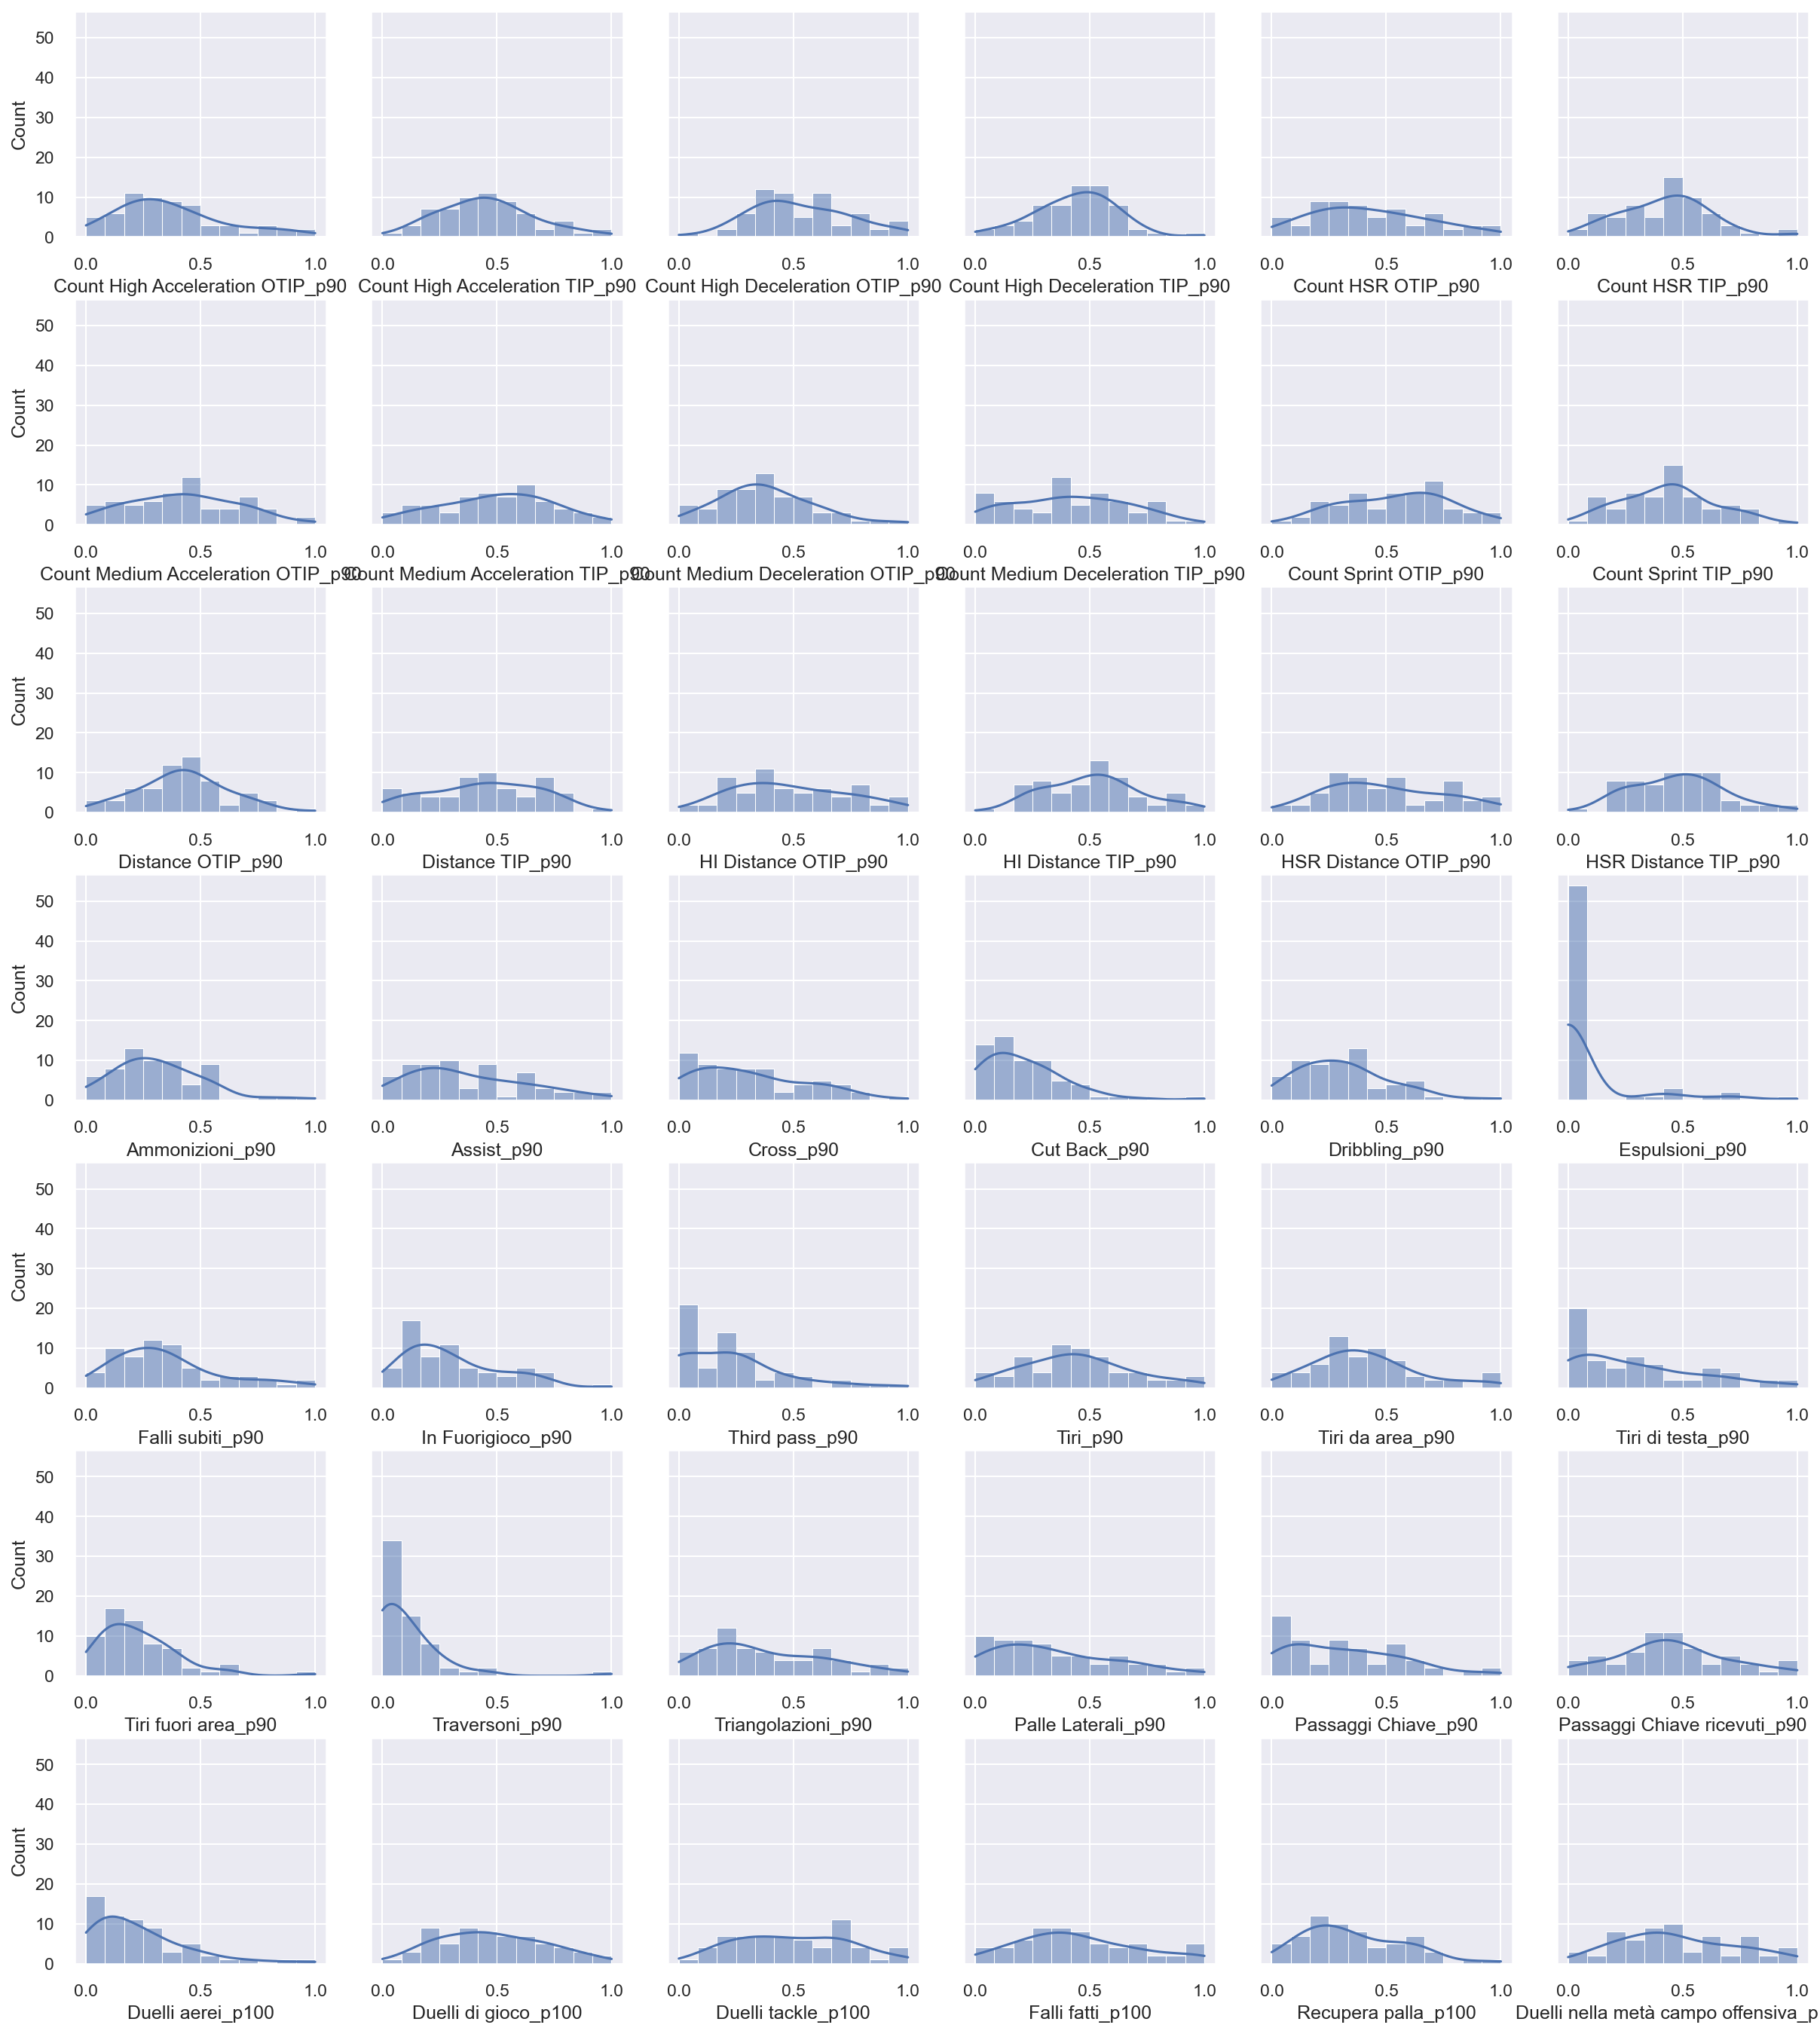

In [74]:
fig, axes = plt.subplots(nrows=7, ncols=6, sharex=False, sharey=True, figsize=(12,12), dpi=150)
#fig.suptitle(f"Feature distributions - General", fontsize=16)
fig.tight_layout(rect=[0, 0, 1.35, 1.5])

for i in np.arange(0, len(df_att.columns)):
    axis = fig.get_axes()[i]
    sns.histplot(data=df_att, x=df_att.iloc[:,i], bins=12, kde=True, linewidth=0.5, ax=axis)

## Reducing components

[Text(0, 0, ''),
 Text(1, 0, '2'),
 Text(2, 0, ''),
 Text(3, 0, '4'),
 Text(4, 0, ''),
 Text(5, 0, '6'),
 Text(6, 0, ''),
 Text(7, 0, '8'),
 Text(8, 0, ''),
 Text(9, 0, '10'),
 Text(10, 0, ''),
 Text(11, 0, '12'),
 Text(12, 0, ''),
 Text(13, 0, '14'),
 Text(14, 0, ''),
 Text(15, 0, '16'),
 Text(16, 0, ''),
 Text(17, 0, '18'),
 Text(18, 0, ''),
 Text(19, 0, '20'),
 Text(20, 0, ''),
 Text(21, 0, '22'),
 Text(22, 0, ''),
 Text(23, 0, '24'),
 Text(24, 0, ''),
 Text(25, 0, '26'),
 Text(26, 0, ''),
 Text(27, 0, '28'),
 Text(28, 0, ''),
 Text(29, 0, '30'),
 Text(30, 0, ''),
 Text(31, 0, '32'),
 Text(32, 0, ''),
 Text(33, 0, '34'),
 Text(34, 0, ''),
 Text(35, 0, '36'),
 Text(36, 0, ''),
 Text(37, 0, '38'),
 Text(38, 0, ''),
 Text(39, 0, '40'),
 Text(40, 0, ''),
 Text(41, 0, '42')]

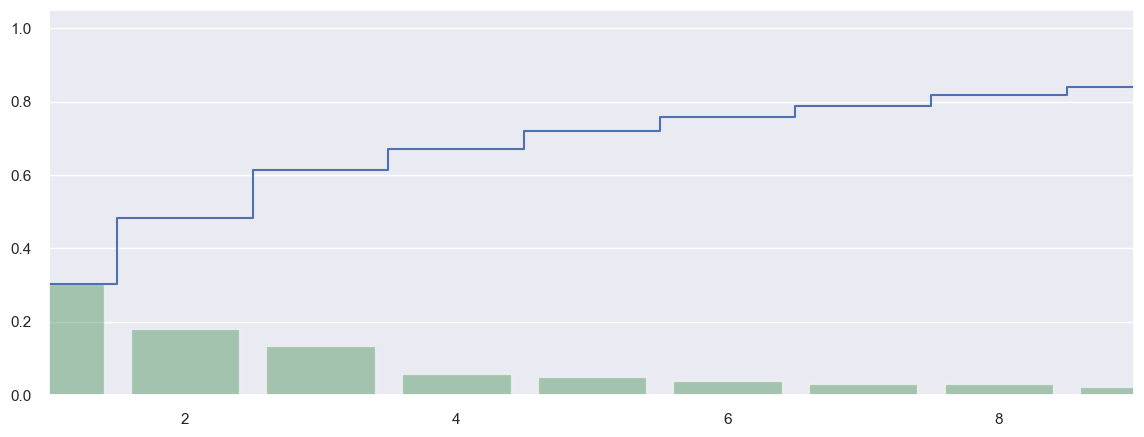

In [75]:
pca = PCA(random_state=0)
pca.fit(df_att)
pca_samples = pca.transform(df_att)

fig, ax = plt.subplots(figsize=(14,5))
sns.set(font_scale=1)
plt.step(range(df_att.shape[1]),pca.explained_variance_ratio_.cumsum(),where='mid',label='cumulative explained variance')
sns.barplot(x = np.arange(1,df_att.shape[1]+1),y = pca.explained_variance_ratio_,alpha=0.5,color = 'g', label = 'individual explained variance')
plt.xlim(0,8)
ax.set_xticklabels([s if int(s.get_text())%2 ==0 else '' for s in ax.get_xticklabels()])


In [76]:
n_components = 7
PCA_components = pd.DataFrame(pca_samples[:,:n_components])
PCA_components.index = df_att.index

PCA_components

0         1         2         3         4         5         6
0    0.215596  1.563716  0.175461 -0.686479  0.100917 -0.120813  0.352699
1    0.389387  0.065347  0.676124 -0.070428 -0.130003 -0.268425 -0.238657
16  -0.524036 -0.773947  0.599964  0.202774  0.273572  0.511273 -0.182162
31   0.361590  0.489475  0.176606 -0.256210  0.142334 -0.222349  0.381437
35  -0.014421  0.963043 -0.220131  0.016739 -0.236651 -0.015039 -0.303415
..        ...       ...       ...       ...       ...       ...       ...
409 -1.029060 -1.151277 -0.705457  0.211198  0.371932 -0.315534  0.238786
455 -0.779438  0.321047  0.827345 -0.035184  0.562832 -0.302417 -0.208517
458 -0.055757 -1.517699  0.186005 -0.011958  0.131027  0.446746  0.397596
462 -0.385938 -0.152805  0.224897 -0.230105 -0.327315  0.233389  0.046959
504  1.175246 -0.141151 -0.463249  0.278935  0.269037 -0.206705  0.360999

[63 rows x 7 columns]

In [77]:
names = df[df.Ruolo=='A'].full_name.to_list()

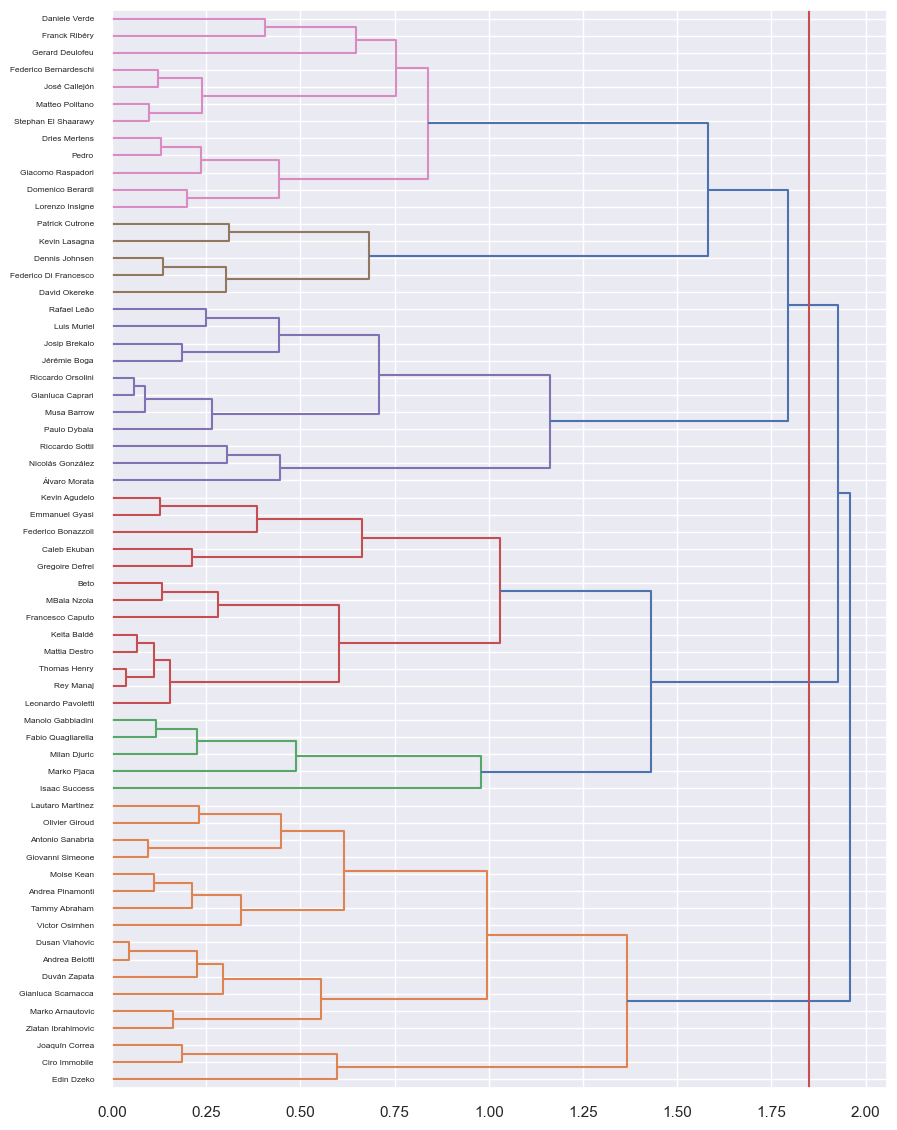

In [78]:
plt.figure(figsize=(10,14))
dendogram = shc.dendrogram(shc.linkage(PCA_components,method='complete',metric= 'cosine'),labels=names, orientation='right')
plt.axvline(x=1.85, color='r', linestyle = '-')

In [79]:
bay_gmm = BayesianGaussianMixture(n_components=4,random_state=0)

In [80]:
bay_gmm.fit(PCA_components)

BayesianGaussianMixture(n_components=4, random_state=0)

In [81]:
bay_gmm_weights = bay_gmm.weights_
np.round(bay_gmm_weights, 2)

array([0.16, 0.37, 0.26, 0.22])

In [82]:
n_clusters_ = (np.round(bay_gmm_weights, 2) > 0).sum()
print('Estimated number of clusters: ' + str(n_clusters_))

Estimated number of clusters: 4


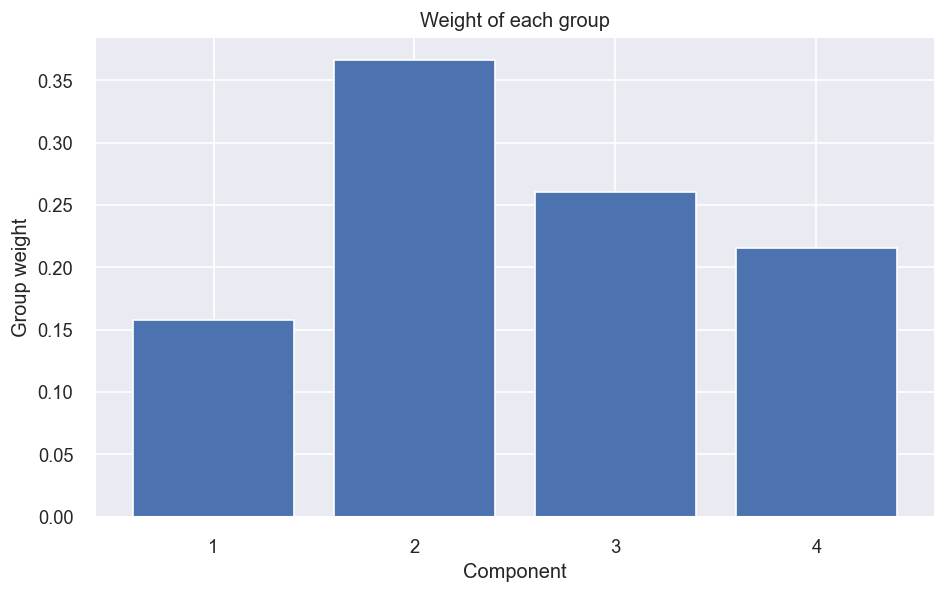

In [83]:
fig = plt.figure(figsize=(7,4), dpi=120)
axes = fig.add_axes([0,0,1,1])
groups = np.arange(len(bay_gmm_weights))
axes.bar(groups, bay_gmm_weights, align='center', alpha=1.0)
plt.xticks(groups, groups + 1)
plt.ylabel('Group weight')
plt.xlabel('Component')
plt.title('Weight of each group')
plt.show()

In [84]:
y_pred  = bay_gmm.predict(PCA_components)

In [85]:
df_att['cluster_bay'] = y_pred

In [86]:
df_att['gm_cluster_prob0'] = bay_gmm.predict_proba(PCA_components)[:,0]
df_att['gm_cluster_prob1'] = bay_gmm.predict_proba(PCA_components)[:,1]
df_att['gm_cluster_prob2'] = bay_gmm.predict_proba(PCA_components)[:,2]
df_att['gm_cluster_prob3'] = bay_gmm.predict_proba(PCA_components)[:,3]

In [87]:
df_att['name']=df[df.Ruolo=='A'].full_name

In [88]:
palette = {
    0: 'blue',
    1: 'green',
    2: 'orange',
    3: 'red',
}

C:\Users\giova\AppData\Local\Temp\ipykernel_15368\2696905598.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df_att, x=df_att.iloc[:,i], hue="cluster_bay", palette= palette, fill=True, linewidth=0, ax=axis,legend = False)


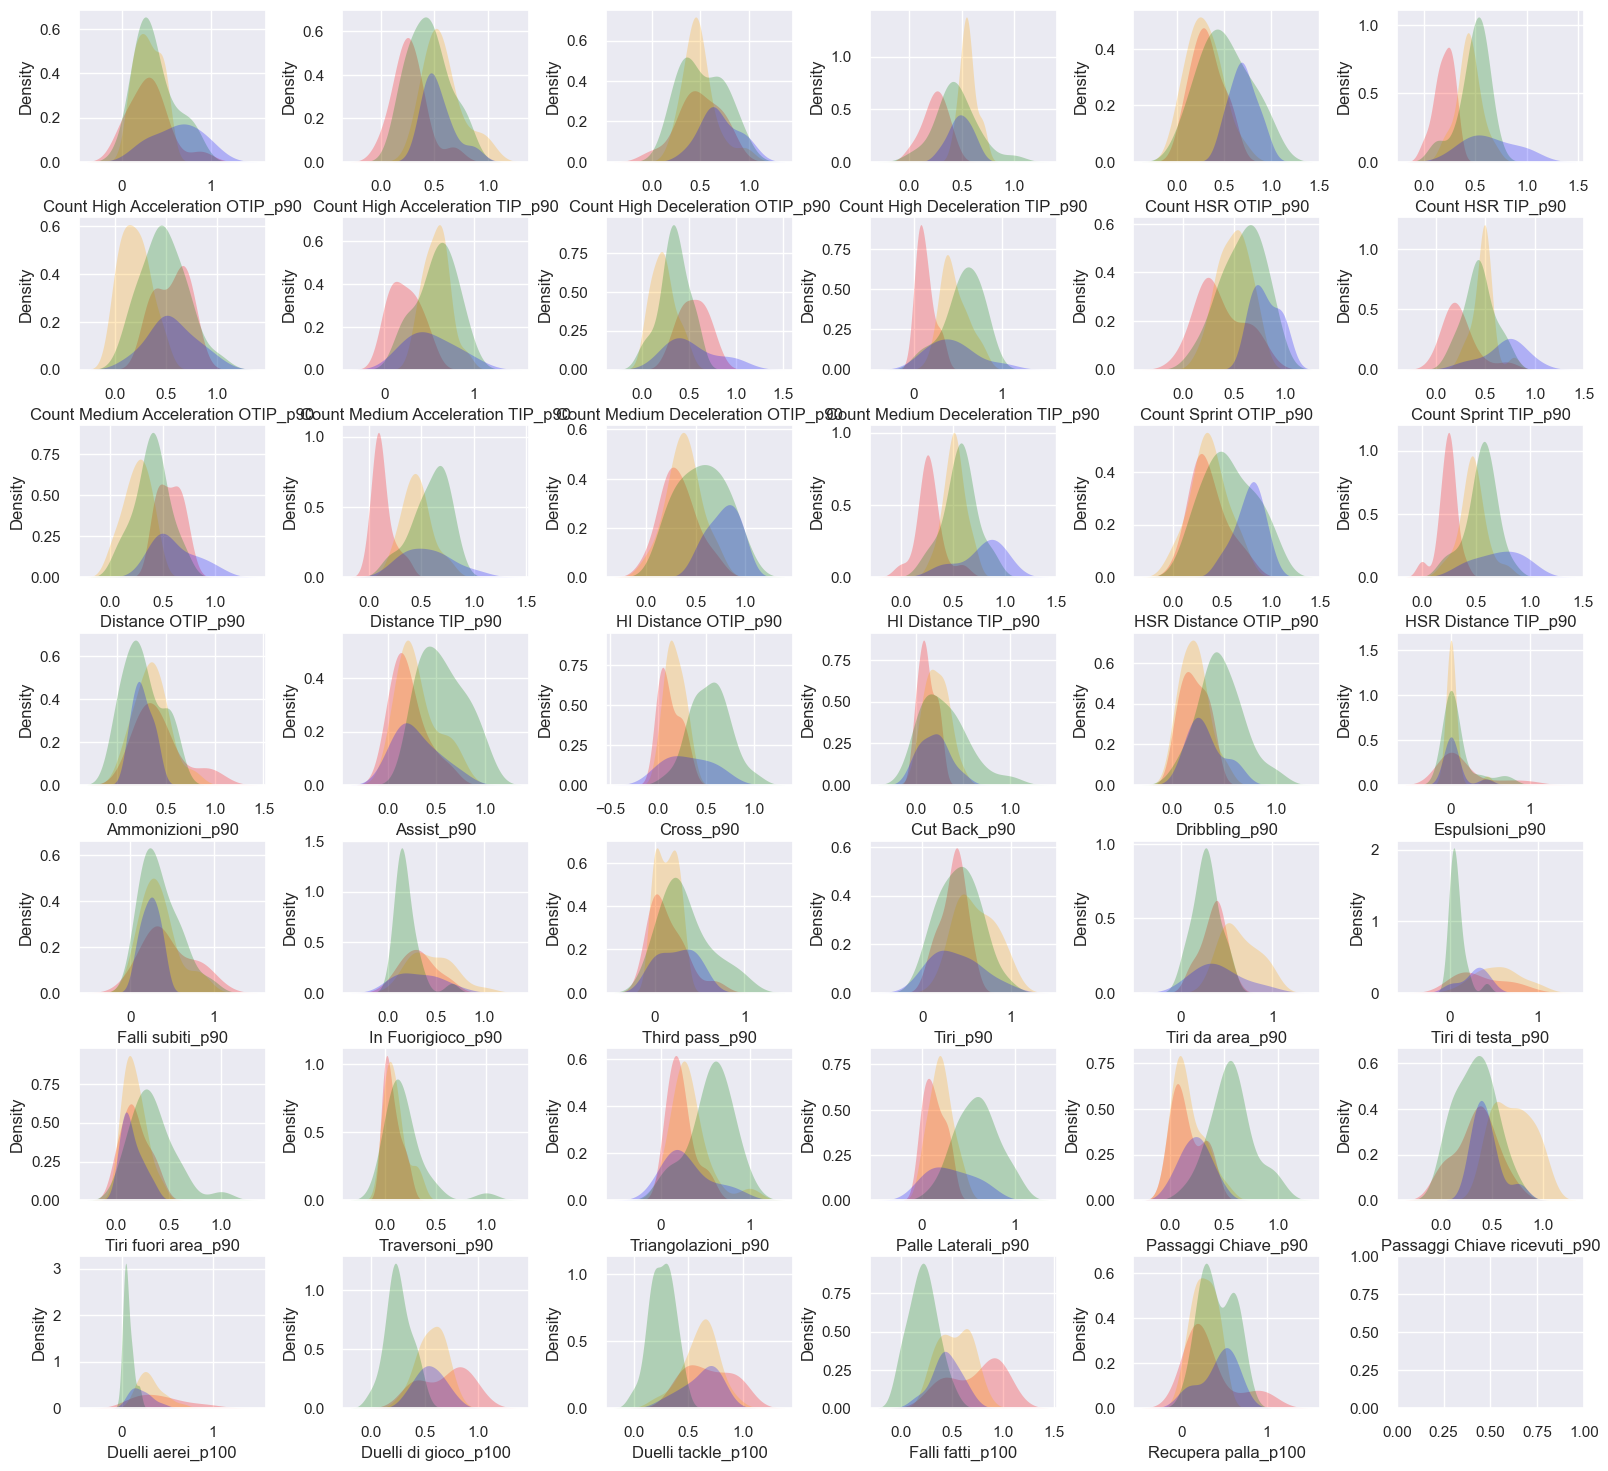

In [89]:
fig, axes = plt.subplots(nrows=7, ncols=6, figsize=(16,16))
#fig.suptitle(f"Feature distributions - by label", fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

for i in np.arange(0, len(df_att[vars].columns)-1):
    axis = fig.get_axes()[i]
    sns.kdeplot(data=df_att, x=df_att.iloc[:,i], hue="cluster_bay", palette= palette, fill=True, linewidth=0, ax=axis,legend = False)
    #plt.legend(loc='upper center')

In [90]:
dfsg_b= df_att.groupby('cluster_bay')[vars].mean()
dfsg_b

Count High Acceleration OTIP_p90  \
cluster_bay                                     
0                                    0.620287   
1                                    0.365786   
2                                    0.295728   
3                                    0.303112   

             Count High Acceleration TIP_p90  \
cluster_bay                                    
0                                   0.535222   
1                                   0.444856   
2                                   0.578615   
3                                   0.267067   

             Count High Deceleration OTIP_p90  \
cluster_bay                                     
0                                    0.698628   
1                                    0.518267   
2                                    0.487599   
3                                    0.486439   

             Count High Deceleration TIP_p90  Count HSR OTIP_p90  \
cluster_bay                                                        
0                                   0.485682            0.698612   
1                                   0.448825            0.506711   
2                                   0.559807            0.283479   
3                                   0.242601            0.312299   

             Count HSR TIP_p90  Count Medium Acceleration OTIP_p90  \
cluster_bay                                                          
0                     0.642394                            0.551235   
1                     0.484236                            0.473364   
2                     0.434678                            0.187620   
3                     0.197022                            0.549293   

             Count Medium Acceleration TIP_p90  \
cluster_bay                                      
0                                     0.518120   
1                                     0.583781   
2                                     0.579336   
3                                     0.227727   

             Count Medium Deceleration OTIP_p90  \
cluster_bay                                       
0                                      0.535268   
1                                      0.341309   
2                                      0.228357   
3                                      0.548792   

             Count Medium Deceleration TIP_p90  ...  Triangolazioni_p90  \
cluster_bay                                     ...                       
0                                     0.440481  ...            0.303320   
1                                     0.560414  ...            0.562255   
2                                     0.460432  ...            0.325591   
3                                     0.125151  ...            0.223535   

             Palle Laterali_p90  Passaggi Chiave_p90  \
cluster_bay                                            
0                      0.318868             0.229734   
1                      0.592432             0.568154   
2                      0.206484             0.167625   
3                      0.133658             0.156994   

             Passaggi Chiave ricevuti_p90  Duelli aerei_p100  \
cluster_bay                                                    
0                                0.446953           0.210643   
1                                0.337063           0.067414   
2                                0.707889           0.315125   
3                                0.342641           0.421402   

             Duelli di gioco_p100  Duelli tackle_p100  Falli fatti_p100  \
cluster_bay                                                               
0                        0.548582            0.615024          0.447135   
1                        0.256988            0.255511          0.218612   
2                        0.564136            0.606187          0.532937   
3                        0.686349            0.683379          0.734104   

             Recupera palla_p100  Duelli nella metà campo offensiva_p100

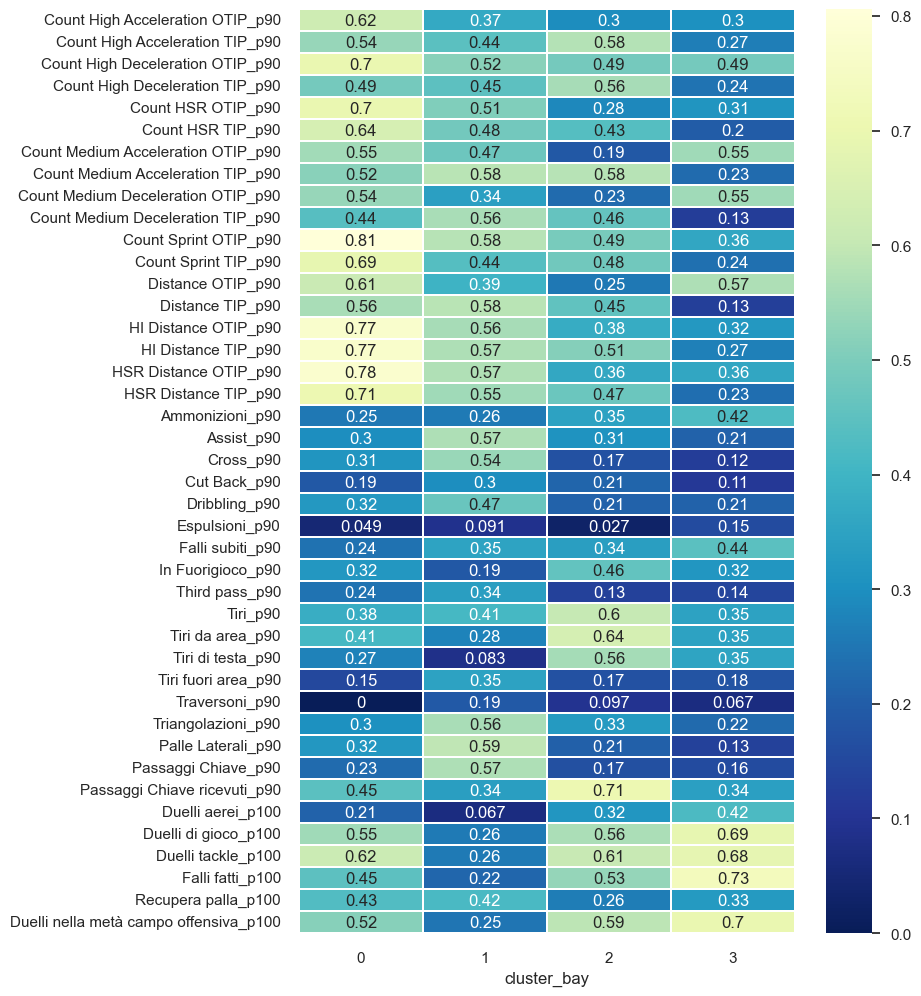

In [91]:
plt.figure(figsize = (8,12))
sns.heatmap(dfsg_b.T, cmap = 'YlGnBu_r',linewidths = 0.30, annot = True)
plt.show()

- Nel primo cluster troviamo attacanti con livelli importanti per quanto riguarda i duelli e metriche fisiche OTIP, ovvero quando l'avversario ha la palla. Si tratta di attacanti che ricevono anche un buon numero di palloni. Si possono trovare quindi giocatori che lottano molto sulla palla e giocano prevalentemente sulla zona centrale. Abbiamo per esempio Ciro Immobile, David Okereke e Kevin Lasagna.

- Nel secondo cluster possiamo notare valori interessanti per quanto riguarda le triangolazioni, palle laterali e passaggi chiave. Un numero elevato di dribbling, cross e cut back. Sono quindi gli attacanti che in misura maggiore forniscono assit. Hanno dei buoni numeri anche per quanto riguarda i tiri totali ma è interessante notare come raramente vadano a colpire di testa. In questo cluster troviamo Paulo Dybala, Lorenzo Insigne, Rafael Leão e Domenico Berardi

- Al terzo cluster appartengono le classiche punte. Tanti passaggi ricevuti e tanti tiri, svettando sugli altri cluster per i tiri di testa. Il classico numero 9. Troviamo in questo cluster giocatori come i Edin Dzeko, Zlatan Ibrahimovic,  Gianluca Scamacca, Antonio Sanabria 

- Questo cluster risulta simile al primo sotto alcuni aspetti. Troviamo il numero maggiore di duelli fra tutti i cluster, con valori sui tiri leggermenti più bassi rispetto al primo. Sono interessanti i valori sui duelli aerei e i bassi valori sulle metriche fisiche TIP. Troviamo in questo cluster giocatori come Mattia Destro, Manolo Gabbiadini, Fabio Quagliarella, Beto

In [92]:
df_att['hybrid'] = df_att[['gm_cluster_prob0', 'gm_cluster_prob1','gm_cluster_prob2','gm_cluster_prob3']].max(axis = 1) < 2./3

In [93]:
df_att[df_att.hybrid][['name', 'cluster_bay', 'gm_cluster_prob0', 'gm_cluster_prob1','gm_cluster_prob2','gm_cluster_prob3']]

name  cluster_bay  gm_cluster_prob0  gm_cluster_prob1  \
53  Francesco Caputo            2          0.019898          0.000043   

    gm_cluster_prob2  gm_cluster_prob3  
53          0.564468           0.41559

## CONCATENAZIONE DEI VARI DATAFRAME

In [94]:
df_dif.rename(columns = {'gm_cluster_prob0':'cluster_0', 'gm_cluster_prob1':'cluster_1',
'gm_cluster_prob2':'cluster_2', 'gm_cluster_prob3':'cluster_3'}, inplace = True)

In [95]:
df_cen.rename(columns = {'gm_cluster_prob0':'cluster_4', 'gm_cluster_prob1':'cluster_5',
'gm_cluster_prob2':'cluster_6', 'gm_cluster_prob3':'cluster_7'}, inplace = True)

In [100]:
df_att.rename(columns = {'gm_cluster_prob0':'cluster_8', 'gm_cluster_prob1':'cluster_9',
'gm_cluster_prob2':'cluster_10', 'gm_cluster_prob3':'cluster_11'}, inplace = True)

In [101]:
df_cen['cluster_bay'] = df_cen.cluster_bay+4
df_att['cluster_bay'] = df_att.cluster_bay+8


In [102]:
df_concat = pd.concat([df_dif, df_cen, df_att ], axis=0)

In [113]:
df_concat[['cluster_bay',	'cluster_0',	'cluster_1',	'cluster_2',	'cluster_3',	'name',	'hybrid',	'cluster_4',	'cluster_5',	'cluster_6',	'cluster_7',	'cluster_8',	'cluster_9',	'cluster_10',	'cluster_11']]

cluster_bay     cluster_0     cluster_1     cluster_2  cluster_3  \
6              3  4.953361e-02  2.201152e-03  3.699823e-06   0.948262   
9              1  5.950192e-08  9.372114e-01  6.181516e-02   0.000973   
12             2  1.838045e-11  1.145298e-02  9.885456e-01   0.000001   
15             3  1.556357e-06  7.608479e-07  7.273618e-09   0.999998   
25             3  1.131448e-07  1.128236e-07  2.923438e-05   0.999971   
..           ...           ...           ...           ...        ...   
409            8           NaN           NaN           NaN        NaN   
455            9           NaN           NaN           NaN        NaN   
458           11           NaN           NaN           NaN        NaN   
462            9           NaN           NaN           NaN        NaN   
504           11           NaN           NaN           NaN        NaN   

                     name  hybrid  cluster_4  cluster_5  cluster_6  cluster_7  \
6       Giorgio Chiellini   False        NaN        NaN        NaN        NaN   
9       Domenico Criscito   False        NaN        NaN        NaN        NaN   
12   Lorenzo De Silvestri   False        NaN        NaN        NaN        NaN   
15       Leonardo Bonucci   False        NaN        NaN        NaN        NaN   
25      Danilo D'Ambrosio   False        NaN        NaN        NaN        NaN   
..                    ...     ...        ...        ...        ...        ...   
409        Dennis Johnsen   False        NaN        NaN        NaN        NaN   
455           Musa Barrow   False        NaN        NaN        NaN        NaN   
458         Kevin Agudelo   False        NaN        NaN        NaN        NaN   
462     Giacomo Raspadori   False        NaN        NaN        NaN        NaN   
504                  Beto   False        NaN        NaN        NaN        NaN   

        cluster_8     cluster_9    cluster_10    cluster_11  
6             NaN           NaN           NaN           NaN  
9             NaN           NaN           NaN           NaN  
12            NaN           NaN           NaN           NaN  
15            NaN           NaN           NaN           NaN  
25            NaN           NaN           NaN           NaN  
..            ...           ...           ...           ...  
409  9.998681e-01  1.318757e-04  3.763594e-12  9.567934e-13  
455  2.469438e-13  9.999939e-01  8.244009e-10  6.128527e-06  
458  1.743172e-03  8.787227e-06  2.044291e-11  9.982480e-01  
462  5.864624e-03  9.925129e-01  9.141073e-04  7.083774e-04  
504  2.661709e-07  9.851033e-14  6.224828e-02  9.377515e-01  

[311 rows x 15 columns]

In [116]:
df_plus = pd.concat([df, df_concat[['cluster_bay',	'cluster_0',	'cluster_1',	'cluster_2',	'cluster_3',	'name',	'hybrid',	'cluster_4',	'cluster_5',	'cluster_6',	'cluster_7',	'cluster_8',	'cluster_9',	'cluster_10',	'cluster_11']]], axis=1)

# COSINE SIMILARITY

In [117]:
scaler = MinMaxScaler()

In [118]:
df[vars]= scaler.fit_transform(df[vars].values)


In [119]:
df[vars].describe()

Count High Acceleration OTIP_p90  Count High Acceleration TIP_p90  \
count                        311.000000                       311.000000   
mean                           0.345487                         0.323398   
std                            0.179176                         0.200260   
min                            0.000000                         0.000000   
25%                            0.221863                         0.156741   
50%                            0.319030                         0.303344   
75%                            0.451925                         0.456461   
max                            1.000000                         1.000000   

       Count High Deceleration OTIP_p90  Count High Deceleration TIP_p90  \
count                        311.000000                       311.000000   
mean                           0.369466                         0.393941   
std                            0.188339                         0.206550   
min                            0.000000                         0.000000   
25%                            0.234799                         0.210595   
50%                            0.352312                         0.369326   
75%                            0.498958                         0.561435   
max                            1.000000                         1.000000   

       Count HSR OTIP_p90  Count HSR TIP_p90  \
count          311.000000         311.000000   
mean             0.403466           0.431632   
std              0.170695           0.238913   
min              0.000000           0.000000   
25%              0.280084           0.194525   
50%              0.400840           0.464219   
75%              0.514584           0.617067   
max              1.000000           1.000000   

       Count Medium Acceleration OTIP_p90  Count Medium Acceleration TIP_p90  \
count                          311.000000                         311.000000   
mean                             0.572354                           0.498585   
std                              0.210833                           0.206210   
min                              0.000000                           0.000000   
25%                              0.461398                           0.338155   
50%                              0.609471                           0.486327   
75%                              0.721528                           0.653253   
max                              1.000000                           1.000000   

       Count Medium Deceleration OTIP_p90  Count Medium Deceleration TIP_p90  \
count                          311.000000                         311.000000   
mean                             0.416671                           0.436897   
std                              0.180192                           0.178680   
min                              0.000000                           0.000000   
25%                              0.285081                           0.301799   
50%                              0.404834                           0.423394   
75%                              0.540069                           0.565153   
max                              1.000000                           1.000000   

       ...  Triangolazioni_p90  Palle Laterali_p90  Passaggi Chiave_p90  \
count  ...          311.000000          311.000000           311.000000   
mean   ...            0.279114            0.207553             0.308248   
std    ...            0.193402            0.181888             0.186838   
min    ...            0.000000            0.000000             0.000000   
25%    ...            0.124923            0.057680             0.179920   
50%    ...            0.254200            0.154059             0.283790   
75%    ...            0.403150            0.332914             0.419524   
max    ...            1.000000            1.000000             1.000000   

       Passaggi Chiave ricevuti_p90  Duelli aerei_p100  Duelli di gioco_p100  \
count 

## Reducing component

Tramite il metodo delle componenti principali si riduce il numero delle colonne (40)

### Analisi componenti principali

[Text(0, 0, ''),
 Text(1, 0, '2'),
 Text(2, 0, ''),
 Text(3, 0, '4'),
 Text(4, 0, ''),
 Text(5, 0, '6'),
 Text(6, 0, ''),
 Text(7, 0, '8'),
 Text(8, 0, ''),
 Text(9, 0, '10'),
 Text(10, 0, ''),
 Text(11, 0, '12'),
 Text(12, 0, ''),
 Text(13, 0, '14'),
 Text(14, 0, ''),
 Text(15, 0, '16'),
 Text(16, 0, ''),
 Text(17, 0, '18'),
 Text(18, 0, ''),
 Text(19, 0, '20'),
 Text(20, 0, ''),
 Text(21, 0, '22'),
 Text(22, 0, ''),
 Text(23, 0, '24'),
 Text(24, 0, ''),
 Text(25, 0, '26'),
 Text(26, 0, ''),
 Text(27, 0, '28'),
 Text(28, 0, ''),
 Text(29, 0, '30'),
 Text(30, 0, ''),
 Text(31, 0, '32'),
 Text(32, 0, ''),
 Text(33, 0, '34'),
 Text(34, 0, ''),
 Text(35, 0, '36'),
 Text(36, 0, ''),
 Text(37, 0, '38'),
 Text(38, 0, ''),
 Text(39, 0, '40'),
 Text(40, 0, ''),
 Text(41, 0, '42')]

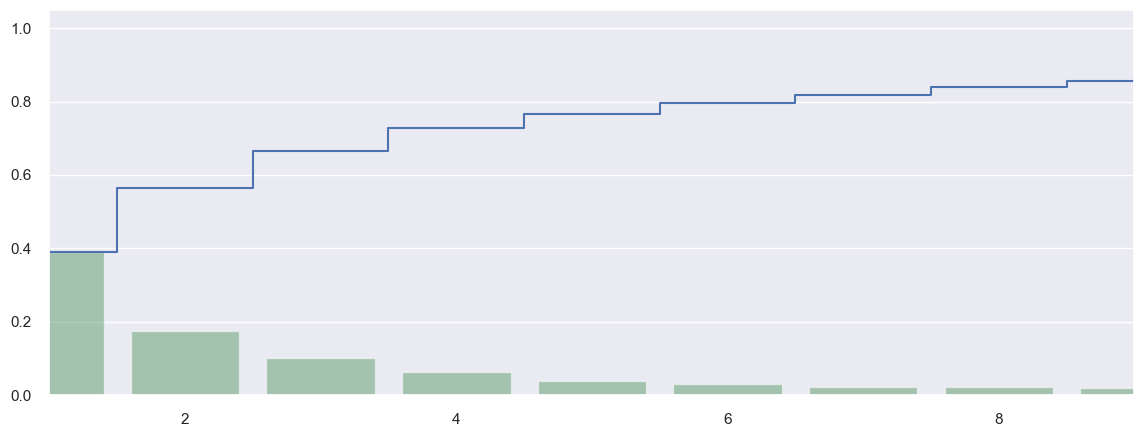

In [120]:
pca = PCA(random_state=0)
pca.fit(df[vars])
pca_samples = pca.transform(df[vars])

fig, ax = plt.subplots(figsize=(14,5))
sns.set(font_scale=1)
plt.step(range(df[vars].shape[1]),pca.explained_variance_ratio_.cumsum(),where='mid',label='cumulative explained variance')
sns.barplot(x = np.arange(1,df[vars].shape[1]+1),y = pca.explained_variance_ratio_,alpha=0.5,color = 'g', label = 'individual explained variance')
plt.xlim(0,8)
ax.set_xticklabels([s if int(s.get_text())%2 ==0 else '' for s in ax.get_xticklabels()])

In order to stay within a perceptible space, the first four components were chosen, and together they absorb nearly 80% of the information. 

In [121]:
n_components = 6
PCA_components = pd.DataFrame(pca_samples[:,:n_components])
PCA_components.index = df[vars].index

In [122]:
PCA_components

0         1         2         3         4         5
0    1.471625  1.097511  0.721914 -0.268411 -0.119597 -0.227283
1    0.526380  0.791763  0.309596  0.048251  0.097181 -0.222839
6   -0.990172  0.298216  0.457548 -0.077820  0.065805 -0.077562
8   -0.601518 -0.184353  0.228442  0.262206  0.239747  0.192748
9   -0.677869 -0.041100  0.071719 -0.280228  0.381380  0.089639
..        ...       ...       ...       ...       ...       ...
517 -1.030814  0.223777 -0.084295 -0.197502 -0.070444 -0.028023
520 -0.923409 -0.039213 -0.198612 -0.124995 -0.056813 -0.115972
527  0.121807 -0.790061 -0.325305 -0.032801  0.244229  0.011514
528  0.193274 -0.646566 -0.238560 -0.203772  0.220776  0.335248
531 -0.627388 -0.149649  0.168633  0.243187  0.086084 -0.258322

[311 rows x 6 columns]

## cosine similarity

In [123]:
cosine_similarities = np.zeros((len(PCA_components), len(PCA_components)))
for i in range(len(PCA_components)):
        for j in range(i+1, len(PCA_components)):
            p1 = PCA_components.iloc[i]
            p2 = PCA_components.iloc[j]

            # Calculate Euclidean distance
            cosine_similarities[i][j] = cosine_similarity([p1], [p2])[0][0]
            cosine_similarities[j][i] = cosine_similarities[i][j]


In [124]:
df_cosine = pd.DataFrame(cosine_similarities,columns=df.full_name.to_list(),index=df.index)

df_cosine.to_csv(f'C:\\Users\\giova\\Documents\\SICS\\Datasets\\df_cosine.csv',encoding='utf-8')

In [112]:
df_final['sim_to'] = prova['Dusan Vlahovic']

In [113]:
 df_final.sort_values(by=['sim_to'], ascending=False)[['name','cluster_bay', 'gm_cluster_prob0', 'gm_cluster_prob1',
       'gm_cluster_prob2', 'gm_cluster_prob3', 'hybrid',
       'gm_cluster_prob4', 'gm_cluster_prob5', 'gm_cluster_prob6',
       'gm_cluster_prob7', 'gm_cluster_prob9',
       'gm_cluster_prob10', 'gm_cluster_prob11', 'gm_cluster_prob12',
       'sim_to']].head(10)

name  cluster_bay  gm_cluster_prob0  gm_cluster_prob1  \
162     Andrea Belotti           11               NaN               NaN   
254      Tammy Abraham           11               NaN               NaN   
320   Lautaro Martínez           11               NaN               NaN   
145       Duván Zapata           11               NaN               NaN   
31    Marko Arnautovic           11               NaN               NaN   
345   Andrea Pinamonti           11               NaN               NaN   
353     Victor Osimhen           11               NaN               NaN   
289  Gianluca Scamacca           11               NaN               NaN   
53    Francesco Caputo           11               NaN               NaN   
237   Giovanni Simeone           11               NaN               NaN   

     gm_cluster_prob2  gm_cluster_prob3  hybrid  gm_cluster_prob4  \
162               NaN               NaN   False               NaN   
254               NaN               NaN   False               NaN   
320               NaN               NaN   False               NaN   
145               NaN               NaN   False               NaN   
31                NaN               NaN   False               NaN   
345               NaN               NaN   False               NaN   
353               NaN               NaN   False               NaN   
289               NaN               NaN   False               NaN   
53                NaN               NaN    True               NaN   
237               NaN               NaN   False               NaN   

     gm_cluster_prob5  gm_cluster_prob6  gm_cluster_prob7  gm_cluster_prob9  \
162               NaN               NaN               NaN      5.787890e-06   
254               NaN               NaN               NaN      3.712028e-02   
320               NaN               NaN               NaN      3.079447e-02   
145               NaN               NaN               NaN      2.279154e-12   
31                NaN               NaN               NaN      3.998943e-08   
345               NaN               NaN               NaN      3.495954e-04   
353               NaN               NaN               NaN      2.226316e-08   
289               NaN               NaN               NaN      1.829642e-04   
53                NaN               NaN               NaN      1.989780e-02   
237               NaN               NaN               NaN      2.888054e-02   

     gm_cluster_prob10  gm_cluster_prob11  gm_cluster_prob12    sim_to  
162       3.178107e-12           0.999476       5.187012e-04  0.992867  
254       3.255502e-05           0.962480       3.669276e-04  0.984549  
320       1.483257e-06           0.969203       7.726061e-07  0.978740  
145       9.797133e-06           0.999990       5.124501e-11  0.975000  
31        5.063402e-05           0.999949       3.043756e-10  0.974462  
345       8.431094e-08           0.976856       2.279450e-02  0.964087  
353       1.968559e-09           1.000000       5.880475e-10  0.963607  
289       1.412490e-07           0.999817       3.134091e-10  0.963233  
53        4.346991e-05           0.564468       4.155903e-01  0.954685  
237       2.351189e-09           0.967777       3.342327e-03  0.953492

## SCRAPING

In [21]:
# Web Scraping
from selenium import webdriver
import requests
from bs4 import BeautifulSoup
import re
from functools import reduce
import pandas as pd

import time

Definizione funzioni per fare scraping della bio e dello status da transfermarkt

In [22]:
# Per fare soup dato url

def get_souped_page(page_url):
    headers = {'User-Agent':
               'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'}

    pageTree = requests.get(page_url, headers=headers)
    pageSoup = BeautifulSoup(pageTree.content, 'html.parser')

    return (pageSoup)


# scraping delle statistiche di bio del giocatore

def get_bio(pageSoup, player_id):
    values = []
    keys = []
    play_and_team = []
    max_val = []
    mkt = []
    title_name = pageSoup.select('h1')[0].get_text().replace(
        '\n', '').replace('  ', '').strip()
    name = re.sub(r'[^a-zA-Z]', ' ', title_name).strip()
    # i giocatori ritirati o che non hanno un club non hanno il numero
    try:
        num = re.findall(r'\d+', title_name)[0]
    except:
        num = None
    info_table = pageSoup.select(
        'div.large-6.large-pull-6.small-12.columns.spielerdatenundfakten')

    for i in info_table[0].find_all("span", class_="info-table__content info-table__content--bold"):
        values.append(i.text.replace('\n', '').strip())
    for i in info_table[0].find_all("span", class_="info-table__content info-table__content--regular"):
        keys.append(i.text.replace('\n', '').strip())
    for i in info_table[0].find_all("span", class_="info-table__content info-table__content--bold info-table__content--flex"):
        play_and_team.append(i.text.replace('\n', '').strip())
    mkt.append(pageSoup.select('div.tm-player-market-value-development__current-value')
               [0].get_text().replace('\n', '').strip())
    max_val.append(pageSoup.select('div.tm-player-market-value-development__max')
                   [0].get_text().split(':')[1].strip().split('\n'))

    if 'Name in home country:' not in keys:
        values.insert(0, None)
        keys.insert(0, 'Name in home country')

    lista = ['Player agent:', 'Current club:']
    for j in lista:
        if j in keys:
            keys.remove(j)

    keys = [k.replace(':', '') for k in keys]

    bio = dict(zip(keys, values))

    if len(play_and_team) > 1:
        bio.update({"Player agent": play_and_team[0],
                    "Current club": play_and_team[1]})
    else:
        bio.update({"Player agent": None,
                    "Current club": play_and_team[0]})

    if len(max_val[0]) > 1:
        bio.update({"Max_Val": max_val[0][0], "Date_Max_Val": max_val[0][1]})
    else:
        bio.update({"Max_Val": max_val[0], "Date_Max_Val": None})

    bio.update({"Name": name, "Player_id": player_id,
               "Numero": num, "Valore": mkt[0]})

    return (bio)


# scraping delle statistiche di status del giocatore

def get_specific_statistics(pageSoup, name):
    lista = pageSoup.select('tfoot')[1].get_text().replace(
        '  ', '').replace('\n', '').strip().split(',')
    new_values = []
    new_keys = []
    for i in lista:
        new_keys.append(i.split(':')[0])
        new_values.append(i.split(':')[1])

    bio_stat = dict(zip(new_keys, new_values))
    bio_stat.update({"Giocatore": name})

    return (bio_stat)


# funzione generale per ottenere diverse possibili statistiche per un giocatore

def tm_pull(player_page, player_bio=False, performance_data=False):
    campionato = 'IT1'
    stagione = '2021'
    player_id = player_page.split("/")[-1:][0]
    output_dict = {}

    if player_bio:

        raw_base_page = get_souped_page(player_page)
        bio = get_bio(raw_base_page, player_id)
        output_dict['player_bio'] = pd.DataFrame.from_dict(
            bio, orient="index").transpose()

    if performance_data:
        pageSoup = get_souped_page(player_page)
        title_name = pageSoup.select('h1')[0].get_text().replace(
            '\n', '').replace('  ', '').strip()
        name = re.sub(r'[^a-zA-Z]', ' ', title_name).strip()

        player_statistics = player_page.replace(
            '/profil/', '/leistungsdatendetails/') + f'/wettbewerb/{campionato}/saison/{stagione}'
        raw_base_page_stat = get_souped_page(player_statistics)

        performance = get_specific_statistics(raw_base_page_stat, name)

        output_dict['performance'] = pd.DataFrame.from_dict(
            performance, orient="index").transpose()

    return (output_dict)


# ottenere i link di tutti i giocatori di una certa squadra

def get_player_urls_from_club_page(club_url):
    '''
    From a club page such as :
    https://www.transfermarkt.com/manchester-united/startseite/verein/985/saison_id/2019
    retrived the url links for all players
    '''
    club_base_page = get_souped_page(club_url)

    player_urls = []
    for row in club_base_page.find_all('table', 'items')[0].select('tr'):
        for item in row.find_all('td', 'hauptlink'):
            try:
                link = item.select('a')[0]['href']
                if link != None:
                    if len(link) > 0:
                        link = link.replace('marktwertverlauf', 'profil')
                        player_urls.append(
                            "https://www.transfermarkt.com" + link)
            except:
                pass

    return (list(set(player_urls)))


def get_club_urls_from_league_page(club_url):
    '''
    From a league page such as :
    https://www.transfermarkt.com/premier-league/startseite/wettbewerb/GB1
    retrived the url links for all clubs
    '''

    league_base_page = get_souped_page(club_url)

    club_urls = []
    for row in league_base_page.find_all('table', 'items')[0].select('tr'):
        for item in row.find_all('td', 'hauptlink'):
            try:
                link = item.select('a')[0]['href']
                if link != None:
                    if len(link) > 0:
                        club_urls.append("https://www.transfermarkt.com" + link)
            except:
                pass

    return(list(set(club_urls)))


def get_player_urls_from_league_page(league_url, verbose = False):
    '''
    From a league page such as :
    https://www.transfermarkt.com/premier-league/startseite/wettbewerb/GB1
    retrived the url links for all players from all clubs

    if you want to check on progress chhange verbose to True
    '''
    players = []

    clubs = get_club_urls_from_league_page(league_url)
    for c in clubs:
        players = players +  get_player_urls_from_club_page(c)
        if verbose:
            print(c.split("/")[3].replace("-", " "), "players added")
    return(players)

SERIE A CODICE IT1

In [55]:
link_serie_a = 'https://www.transfermarkt.com/serie-a/startseite/wettbewerb/IT1/plus/?saison_id=2021'
list_url_teams = get_club_urls_from_league_page(link_serie_a)

In [56]:
list_url_teams

['https://www.transfermarkt.com/sampdoria-genua/startseite/verein/1038/saison_id/2021',
 'https://www.transfermarkt.com/ssc-neapel/startseite/verein/6195/saison_id/2021',
 'https://www.transfermarkt.com/hellas-verona/startseite/verein/276/saison_id/2021',
 'https://www.transfermarkt.com/us-sassuolo/startseite/verein/6574/saison_id/2021',
 'https://www.transfermarkt.com/fc-bologna/startseite/verein/1025/saison_id/2021',
 'https://www.transfermarkt.com/genua-cfc/startseite/verein/252/saison_id/2021',
 'https://www.transfermarkt.com/udinese-calcio/startseite/verein/410/saison_id/2021',
 'https://www.transfermarkt.com/us-salernitana-1919/startseite/verein/380/saison_id/2021',
 'https://www.transfermarkt.com/fc-turin/startseite/verein/416/saison_id/2021',
 'https://www.transfermarkt.com/cagliari-calcio/startseite/verein/1390/saison_id/2021',
 'https://www.transfermarkt.com/as-rom/startseite/verein/12/saison_id/2021',
 'https://www.transfermarkt.com/venezia-fc/startseite/verein/607/saison_id

In [35]:
# Per ottenere dataframe con tutti i dati sulla bio di tutti i giocatori
for team in list_url_teams:
    lst_output = get_player_urls_from_club_page(team)
    lst_df_bio = []
    for player_page in lst_output:
        try:
            dict_output = tm_pull(player_page, player_bio=True)
            time.sleep(1)
            df = dict_output['player_bio']
            lst_df_bio.append(df)
            print(f'Bio data appended for: {player_page}')
        except:
            print(f'Unable to append Bio data for: {player_page}')
            pass
    df_bio = pd.concat(lst_df_bio)
    nome = team.split('www.transfermarkt.com/')[1].split('/')[0]
    df_bio.to_csv(f'C:\\Users\\giova\\Documents\\SICS\\Datasets\\bio_teams\\bio_{nome}.csv',index=False,encoding='utf-8')


Bio data appended for: https://www.transfermarkt.com/nicola-murru/profil/spieler/171399
Bio data appended for: https://www.transfermarkt.com/lorenzo-tonelli/profil/spieler/111347
Bio data appended for: https://www.transfermarkt.com/gerard-yepes/profil/spieler/624436
Bio data appended for: https://www.transfermarkt.com/mikkel-damsgaard/profil/spieler/540941
Bio data appended for: https://www.transfermarkt.com/daniele-montevago/profil/spieler/678441
Bio data appended for: https://www.transfermarkt.com/radu-dragusin/profil/spieler/568559
Bio data appended for: https://www.transfermarkt.com/wladimiro-falcone/profil/spieler/238537
Bio data appended for: https://www.transfermarkt.com/tomas-rincon/profil/spieler/75942
Bio data appended for: https://www.transfermarkt.com/riccardo-ciervo/profil/spieler/628558
Bio data appended for: https://www.transfermarkt.com/antonio-candreva/profil/spieler/25488
Bio data appended for: https://www.transfermarkt.com/stefano-sensi/profil/spieler/216179
Bio data

In [39]:
# df completo

path = 'C:\\Users\\giova\\Documents\\SICS\\Datasets\\bio_teams'

all_files = glob.glob(os.path.join(path, "*.csv"))
df_bio_final = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

In [40]:
df_bio_final.to_csv('C:\\Users\\giova\\Documents\\SICS\\Datasets\\df_bio_final.csv',index=False,encoding='utf-8')

Su questo dataset salvato ho poi dovuto fare dele trasformazioni con excel in modo da poter associare ai giocatori il player_id del dataframe ottenuto mergiando tutti i df dati a disposizione (N.B. ho sistemato e associato id solamente ai 311 giocatori del df filtrato, tutti gli altri hanno id = 99999999). Ho salvato poi il df modificato in questa directory di lavoro con il nome di df_bio_final

In [57]:
# Per ottenere dataframe con tutti i dati sulla bio di tutti i giocatori
for team in list_url_teams:
    lst_output = get_player_urls_from_club_page(team)
    lst_df_status = []
    for player_page in lst_output:
        try:
            dict_output = tm_pull(player_page, performance_data=True)
            time.sleep(1)
            df = dict_output['performance']
            lst_df_status.append(df)
            print(f'Bio data appended for: {player_page}')
        except:
            print(f'Unable to append Bio data for: {player_page}')
            pass
    df_status = pd.concat(lst_df_status)
    nome = team.split('www.transfermarkt.com/')[1].split('/')[0]
    df_status.to_csv(f'C:\\Users\\giova\\Documents\\SICS\\Datasets\\bio_teams\\status_{nome}.csv',index=False,encoding='utf-8')


Bio data appended for: https://www.transfermarkt.com/nicola-murru/profil/spieler/171399
Bio data appended for: https://www.transfermarkt.com/lorenzo-tonelli/profil/spieler/111347
Bio data appended for: https://www.transfermarkt.com/gerard-yepes/profil/spieler/624436
Bio data appended for: https://www.transfermarkt.com/mikkel-damsgaard/profil/spieler/540941
Bio data appended for: https://www.transfermarkt.com/daniele-montevago/profil/spieler/678441
Bio data appended for: https://www.transfermarkt.com/radu-dragusin/profil/spieler/568559
Bio data appended for: https://www.transfermarkt.com/wladimiro-falcone/profil/spieler/238537
Bio data appended for: https://www.transfermarkt.com/tomas-rincon/profil/spieler/75942
Bio data appended for: https://www.transfermarkt.com/riccardo-ciervo/profil/spieler/628558
Bio data appended for: https://www.transfermarkt.com/antonio-candreva/profil/spieler/25488
Bio data appended for: https://www.transfermarkt.com/stefano-sensi/profil/spieler/216179
Bio data

In [59]:
# df completo

path = 'C:\\Users\\giova\\Documents\\SICS\\Datasets\\bio_teams'

all_files = glob.glob(os.path.join(path, "*.csv"))
df_status_final = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

In [60]:
df_status_final.to_csv('C:\\Users\\giova\\Documents\\SICS\\Datasets\\df_status_final.csv',index=False,encoding='utf-8')

Stesso ragionamento per quanto riguarda il dataframe precedente: utilizzo di excel per associazione ID. Anche in questo caso per i giocatori non presenti nel df ottenuto dall'unione di tutti gli altri è stato associato un id di 99999999

## Import e merge dei df di scraping

In [125]:
df_bio = pd.read_csv('df_bio_final.csv',sep=';')

In [126]:
df_status = pd.read_csv('df_status_final.csv',sep=';')

## Merge con df

In [128]:
df_m_bio = df_plus.merge(df_bio, left_on = 'Player ID', right_on = 'Player_id', how = 'inner')

In [129]:
df_final = df_m_bio.merge(df_status, left_on = 'Player_id', right_on = 'Player_id', how = 'inner')

In [130]:
df_final.to_csv(f'C:\\Users\\giova\\Documents\\SICS\\Datasets\\df_final.csv',encoding='utf-8')